# Introduccion:


**Pregunta de investigación**

¿Cómo predecir los tiempos de entrega y el cumplimiento de las promesas de entrega en una empresa de reparto a domicilio de productos de supermercado mediante el uso de  modelos predictivos  y estrategias operativas basadas en datos?

**propuesta de solución**


La predicción de la hora de entrega de un producto podría estar relacionada a los datos presentes en la base de datos y a las particularidades de sus características a analizar, así como  podría ser la hora del pedido, el día, distancias, rendimiento de los recolectores, entre otras .Que funcionará bajo el supuesto de que el pedido se hace durante el día y en la jornada laboral común es decir de las 08:00 horas hasta las 18:00, esto con el fin de mejorar la interpretación de horas de entrega ambiguas y así poder responder si la predicción de entrega es para el mismo día o se debe interpretar como una hora de entrega para el día siguiente, para entender ésto


## Orden_compra:
    - id_orden: Identificador del pedido de compra.
    - Latitud: Dirección de entrega.
    - Longitud: Dirección de entrega.
    - Día: Día de la semana en que se prometió la orden.
    - 0: Domingo.
    - 1: Lunes.
    - 2: Martes.
    - 3: Miércoles.
    - 4: Jueves.
    - 5: Viernes.
    - 6: Sábado.
    - Promesa: Hora de entrega prometida al cliente.
    - Entrega: Hora en que se entregó el pedido al cliente
    - id_entrega: Si el pedido fue solicitado en “Menos de 90 minutos” o en una ventana horario en el futuro.
    - id_recolector: Identificador de la persona que recolectó el pedido.
    - id_transporte: Identificador de la persona que hizo transporte del pedido.
    - id_local: Identificador del local en que se realizó la compra.
    - Tiempo: Tiempo total que demoró completar la orden (desde la compra hasta la entrega).

## Orden_productos:
    - id_orden: Identificador del pedido de compra.
    - id_productos: Identificador del producto.
    - cant_producto: Cantidad solicitada del producto por el cliente.
    - cant_encontrada: Cantidad solicitada del producto por el cliente.
    - Unidad: Formato en que se vendió el producto (Unidades o KG).

## Recolector:
    - id_recolector: Identificador recolector.
    - Clasificación_recolector: Clasificación de experiencia recolector.
    - P_aciertos: Porcentaje histórico de productos que el recolector encontró.
    - Velocidad: Velocidad histórica de recogida de productos.
    - P_aceptacion: Porcentaje histórico de pedidos aceptado por el recolector.
    - Score_Recolector: Evaluación del recolector.

## Tienda:
    - id_Tienda: Identificador de la tienda.
    - tienda: Identificador de la tienda a la cual pertenece la tienda.
    - latitud_tienda: Latitud de la ubicación de la tienda.
    - Longitud_tienda: Longitud de la ubicación de la tienda.

In [94]:
!pip install pygam


In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from scipy import stats
from sklearn.metrics import mean_absolute_error, r2_score

from pygam import LinearGAM, s, f
from sklearn.inspection import permutation_importance

In [96]:
Orden_compra = pd.read_csv(r'/content/1_Orden_compra.csv', sep=';')
Orden_productos = pd.read_csv(r'/content/2_Orden_productos.csv', sep=';')
Recolector = pd.read_csv(r'/content/3_Recolector.csv', sep=';')
Tienda = pd.read_csv(r'/content/4_tienda.csv', sep=';')

# 1_Definiciones-a-utilizar:


In [97]:
def formatear_coord_long(coord):

    coord = coord.replace('.', '')

    if len(coord) == 18:
        return '-' + coord[1:4] + ',' + coord[4:]
    elif len(coord) == 17:
        return coord[:3] + ',' + coord[3:]
    elif len(coord) == 16:
        return coord[:2] + ',' + coord[2:]
    elif len(coord) == 15:
        return coord[:1] + ',' + coord[1:]
    elif len(coord) == 14:
        return '0,' + coord
    else:
        return coord


def formatear_coord_lat(coord):

    coord = coord.replace('.', '')

    if len(coord) >= 17:
        return coord[:2] + ',' + coord[2:]
    elif len(coord) == 16:
        return coord[:2] + ',' + coord[2:]
    elif len(coord) == 15:
        return coord[:1] + ',' + coord[1:]
    elif len(coord) == 14:
        return '0,' + coord
    elif len(coord) == 13:
        return '0,' + coord
    else:
        return coord


def convertir_a_float(coord):

    coord = coord.replace(',', '.')
    return float(coord)


def calcular_distancia(lat1, lon1, lat2, lon2):


    radio_tierra = 6371


    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)


    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # f haversine
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distancia = radio_tierra * c

    return distancia

def convertir_a_minutos(tiempo_string):


    partes = tiempo_string.split('.')
    minutos = int(partes[0])
    segundos = int(partes[1]) if len(partes) > 1 else 0
    milisegundos = int(partes[2]) if len(partes) > 2 else 0
    total_minutos = minutos + segundos/60 + milisegundos/60000
    return total_minutos


# 2_Tratamiento-de-los-datos

In [98]:
################################################################################################################################################################
###################################################     tratamiento para df Orden_compra               #########################################################
################################################################################################################################################################
def time_string_to_minutes(time_string):
    time_parts = [int(part) for part in time_string.split(':')]
    return time_parts[0] * 60 + time_parts[1] + time_parts[2] / 60


Orden_compra['promised_time'] = Orden_compra['promised_time'].apply(time_string_to_minutes)
Orden_compra['actual_time'] = Orden_compra['actual_time'].apply(time_string_to_minutes)


Orden_compra['on_demand'] = Orden_compra['on_demand'].astype(int)



Orden_productos['buy_unit'] = Orden_productos['buy_unit'].replace({'KG': 0, 'UN': 1})
Orden_productos['quantity_foundkg'] = Orden_productos['quantity_found'].where(Orden_productos['buy_unit'] == 0, 0)
Orden_productos['quantity_foundun'] = Orden_productos['quantity_found'].where(Orden_productos['buy_unit'] == 1, 0)
Orden_productos.drop('quantity_found', axis=1, inplace=True)
Orden_productos.drop('buy_unit', axis=1, inplace=True)




################################################################################################################################################################
###################################################     tratamiento para df Orden_productos               ######################################################
################################################################################################################################################################



Orden_productos['quantity'] = pd.to_numeric(Orden_productos['quantity'], errors='coerce')
sorted_unique_values = sorted(Orden_productos['quantity'].unique().tolist())
valores_unicos = Recolector['seniority'].unique()




################################################################################################################################################################
###################################################     tratamiento para df Recolector               ###########################################################
################################################################################################################################################################


Recolector['seniority'] = Recolector['seniority'].replace({
    'BEGINNER': 0,
    'INTERMEDIATE': 1,
    'ADVANCED': 2,
    'REVIEW': 3
})
Orden_compra = (Orden_compra.dropna())
Orden_productos = (Orden_productos.dropna())
Recolector = (Recolector.dropna())
Tienda = Tienda.dropna()

## Murge

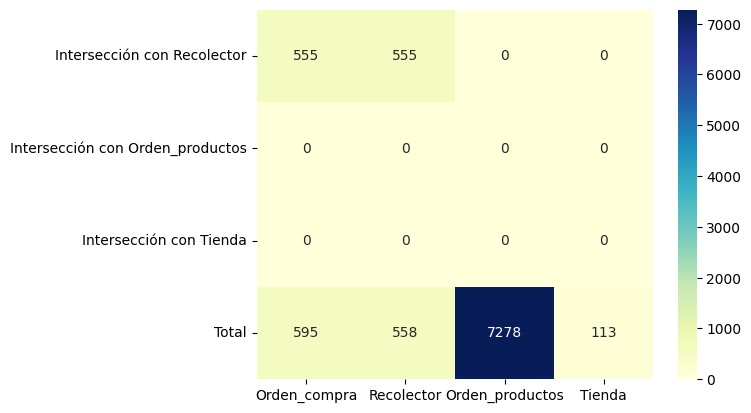

                                  Orden_compra  Recolector  Orden_productos  \
Intersección con Recolector                555         555                0   
Intersección con Orden_productos             0           0                0   
Intersección con Tienda                      0           0                0   
Total                                      595         558             7278   

                                  Tienda  
Intersección con Recolector            0  
Intersección con Orden_productos       0  
Intersección con Tienda                0  
Total                                113  


In [99]:
set1 = set(Orden_compra['picker_id'].unique())
set2 = set(Recolector['shopper_id'].unique())
set3 = set(Orden_productos['order_id'].unique())
set4 = set(Tienda['store_branch_id'].unique())


data = {
    'Orden_compra': [len(set1 & set2), len(set1 & set3), len(set1 & set4), len(set1)],
    'Recolector': [len(set2 & set1), len(set2 & set3), len(set2 & set4), len(set2)],
    'Orden_productos': [len(set3 & set1), len(set3 & set2), len(set3 & set4), len(set3)],
    'Tienda': [len(set4 & set1), len(set4 & set2), len(set4 & set3), len(set4)]
}

df = pd.DataFrame(data, index=['Intersección con Recolector', 'Intersección con Orden_productos', 'Intersección con Tienda', 'Total'])
sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu")
plt.show()
print(df)

df_merge = pd.merge(Orden_compra, Recolector, left_on='picker_id', right_on='shopper_id', how='left')


df_merge = pd.merge(df_merge, Orden_productos, on='order_id', how='left')


df_merge = pd.merge(df_merge, Tienda, on='store_branch_id', how='left')


df_merge = df_merge.dropna()
df_merge = df_merge.drop_duplicates()

In [100]:
df_merge['lat_x'] = df_merge['lat_x'].astype('object').apply(formatear_coord_lat)
df_merge['lng_x'] = df_merge['lng_x'].astype('object').apply(formatear_coord_long)
df_merge['lat_y'] = df_merge['lat_y'].astype('object').apply(formatear_coord_lat)
df_merge['lng_y'] = df_merge['lng_y'].astype('object').apply(formatear_coord_long)

# Convertir columnas a tipo float
df_merge['lat_x'] = df_merge['lat_x'].apply(convertir_a_float)
df_merge['lng_x'] = df_merge['lng_x'].apply(convertir_a_float)
df_merge['lat_y'] = df_merge['lat_y'].apply(convertir_a_float)
df_merge['lng_y'] = df_merge['lng_y'].apply(convertir_a_float)

# Calcular la distancia entre las coordenadas de latitud y longitud_  distancia en kilómetros
df_merge['distancia'] = df_merge.apply(lambda row: calcular_distancia(row['lat_x'], row['lng_x'], row['lat_y'], row['lng_y']), axis=1)


# Al calcular distancia en función de las latitudes y longitudes, las vamos a eliminar para simplificar el análisis posterior
col_drop_1= ['lat_x', 'lng_x', 'lat_y', 'lng_y']

# Eliminar las columnas del DataFrame
df_merge = df_merge.drop(col_drop_1, axis=1)



df_merge['total_minutes'] = df_merge['total_minutes'].apply(convertir_a_minutos)



In [101]:
valores_unicos = Orden_compra['on_demand'].unique()

# 3_graficos-y-Correlaciones

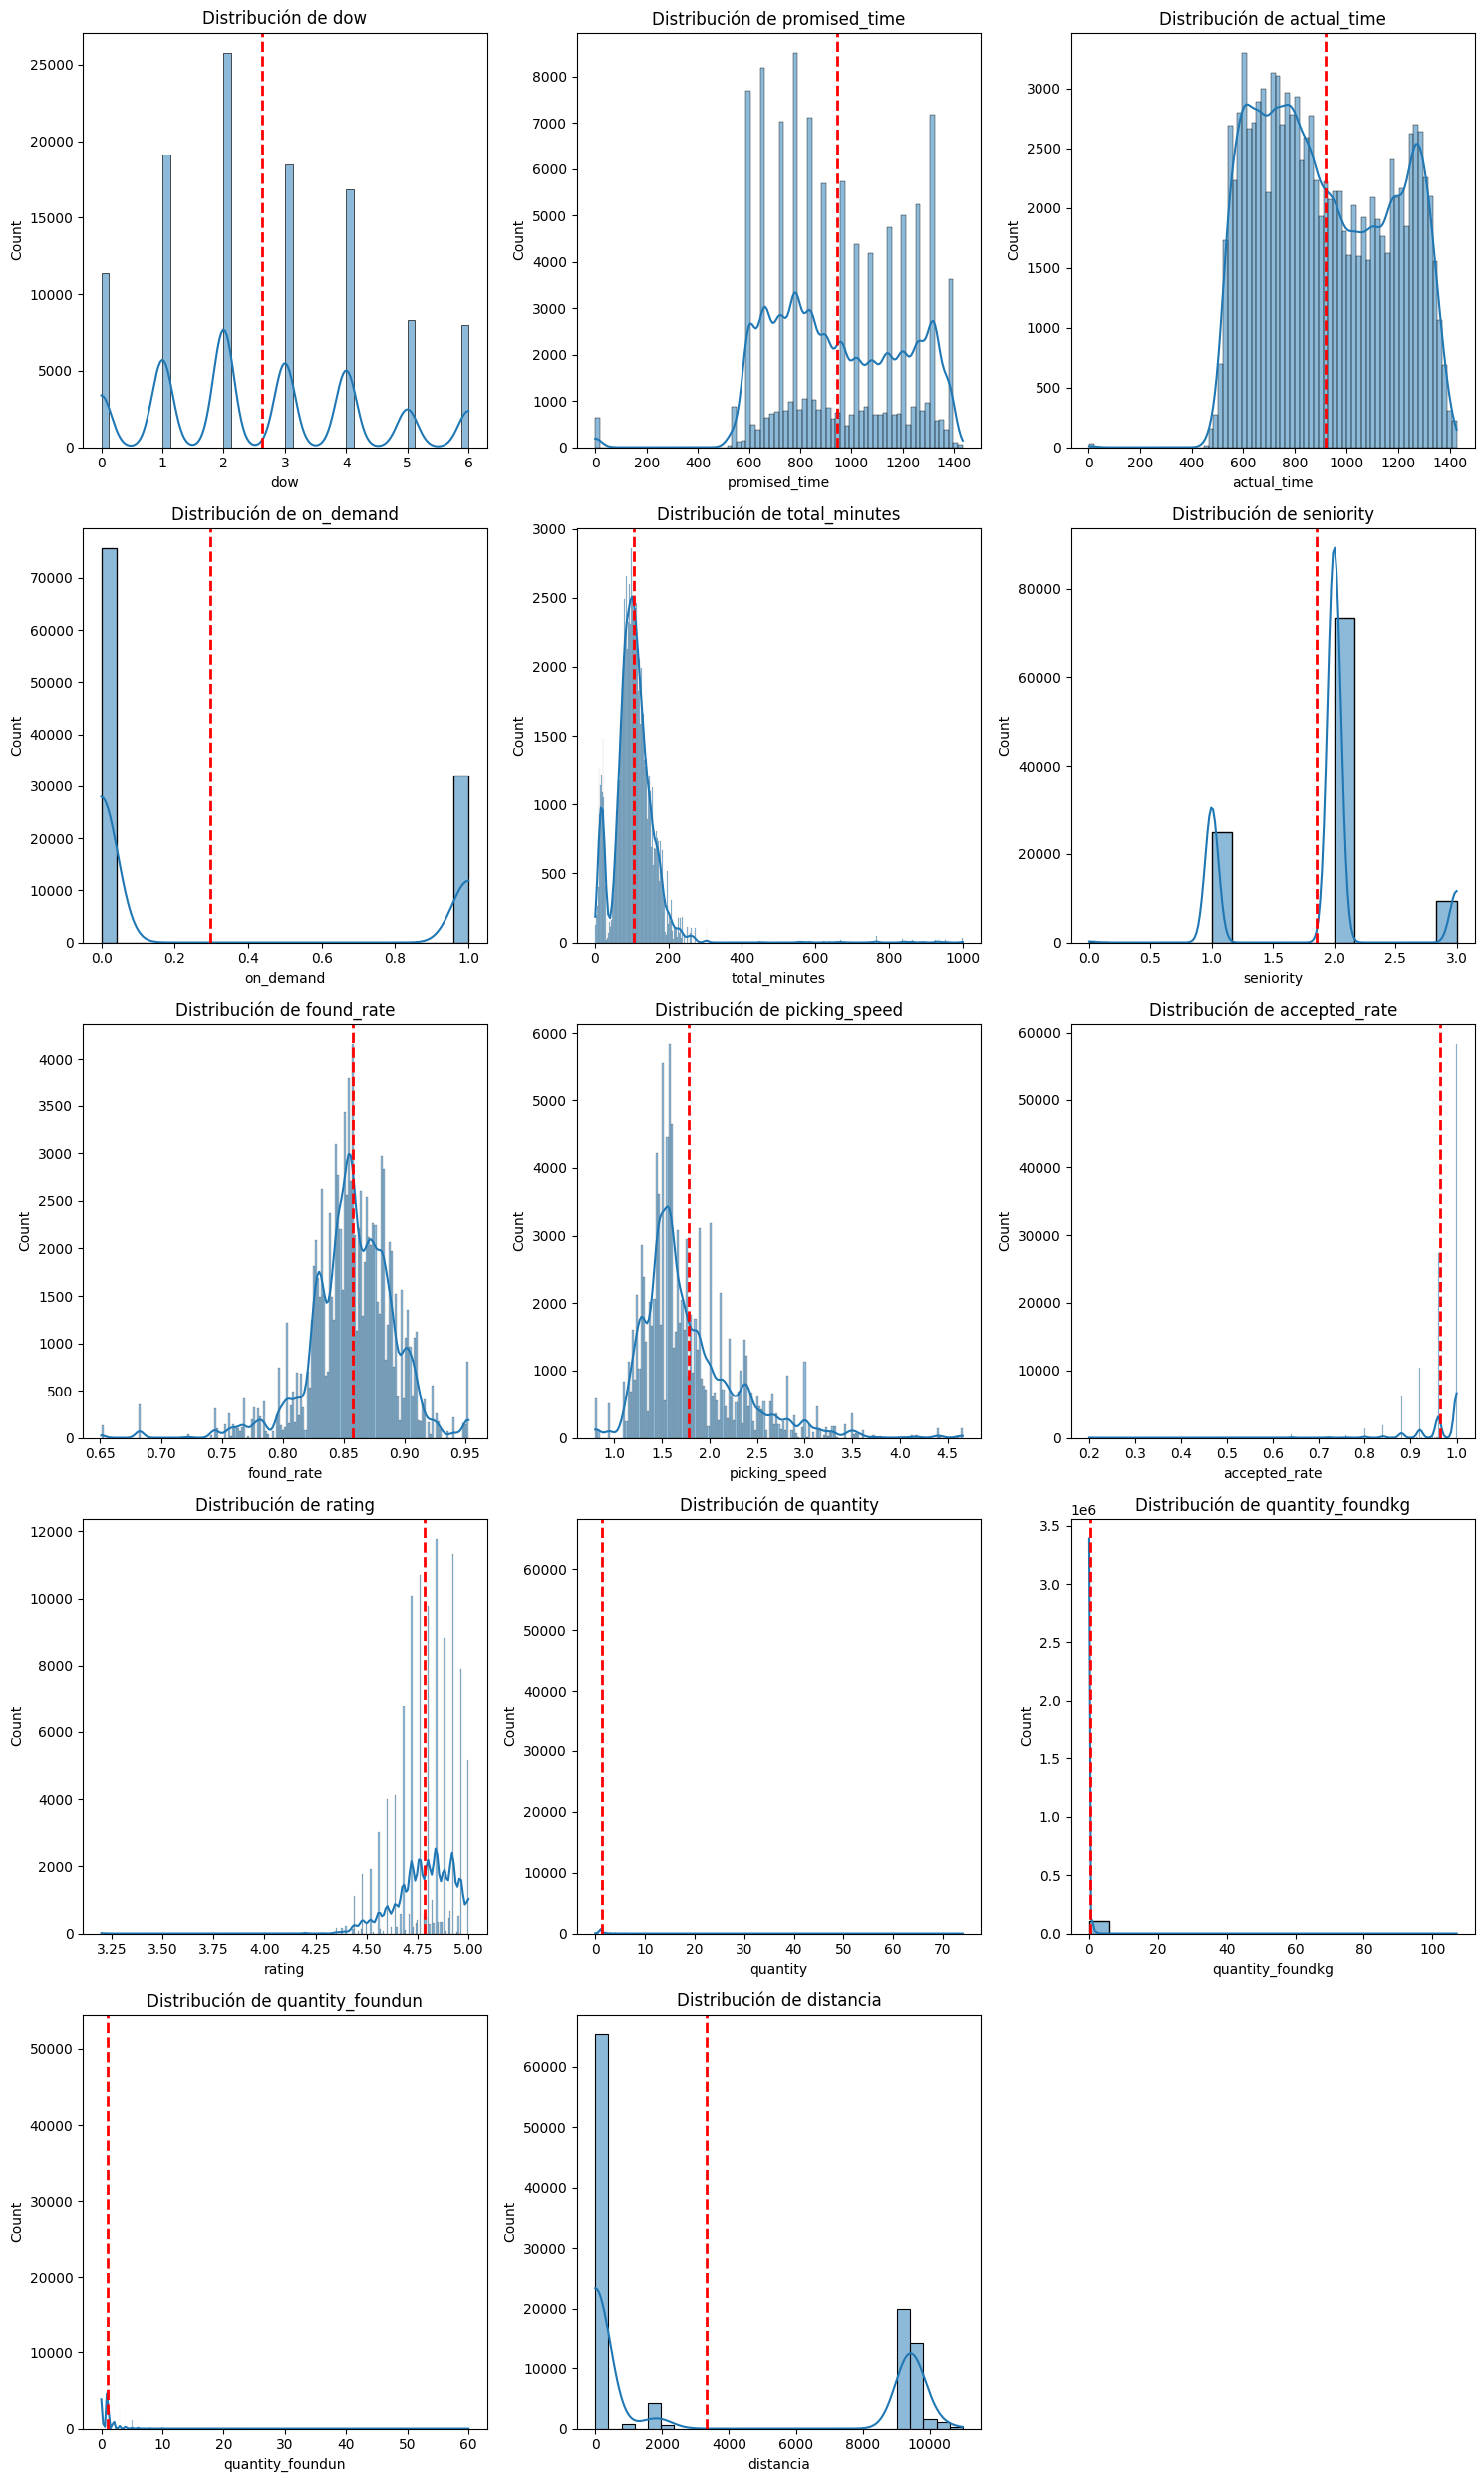

In [102]:
numerical_cols = df_merge.select_dtypes(include=['int64', 'float64']).columns
n = len(numerical_cols)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows*5))


axes = axes.ravel()


for i, col in enumerate(numerical_cols):
    sns.histplot(data=df_merge, x=col, kde=True, ax=axes[i])
    axes[i].axvline(df_merge[col].mean(), color='red', linestyle='dashed', linewidth=2)
    axes[i].set_title('Distribución de ' + col)
    axes[i].autoscale(enable=True, axis='y')


if len(numerical_cols) < len(axes):
    for j in range(len(numerical_cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

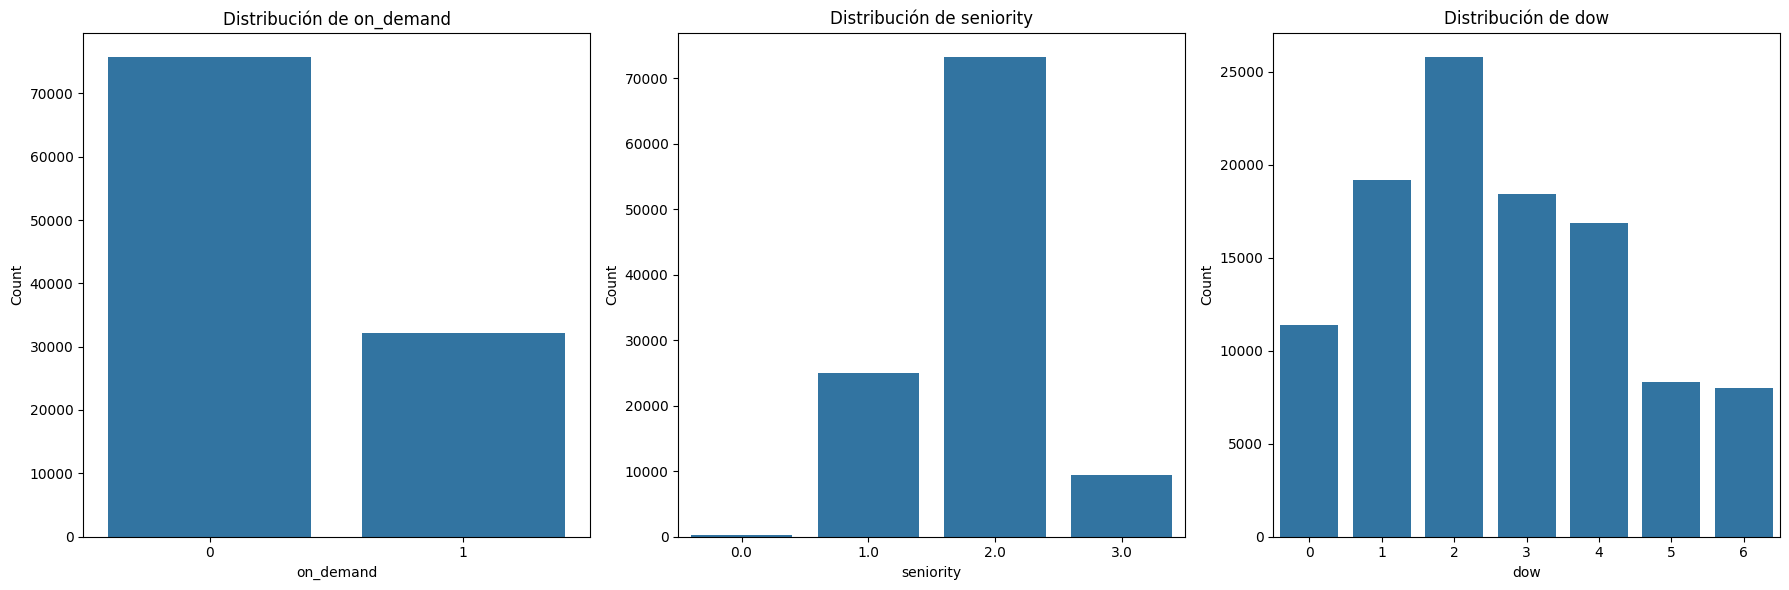

In [103]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(data=df_merge, x='on_demand', ax=axes[0])
axes[0].set_title('Distribución de on_demand')
axes[0].set_xlabel('on_demand')
axes[0].set_ylabel('Count')

sns.countplot(data=df_merge, x='seniority', ax=axes[1])
axes[1].set_title('Distribución de seniority')
axes[1].set_xlabel('seniority')
axes[1].set_ylabel('Count')

sns.countplot(data=df_merge, x='dow', ax=axes[2])
axes[2].set_title('Distribución de dow')
axes[2].set_xlabel('dow')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

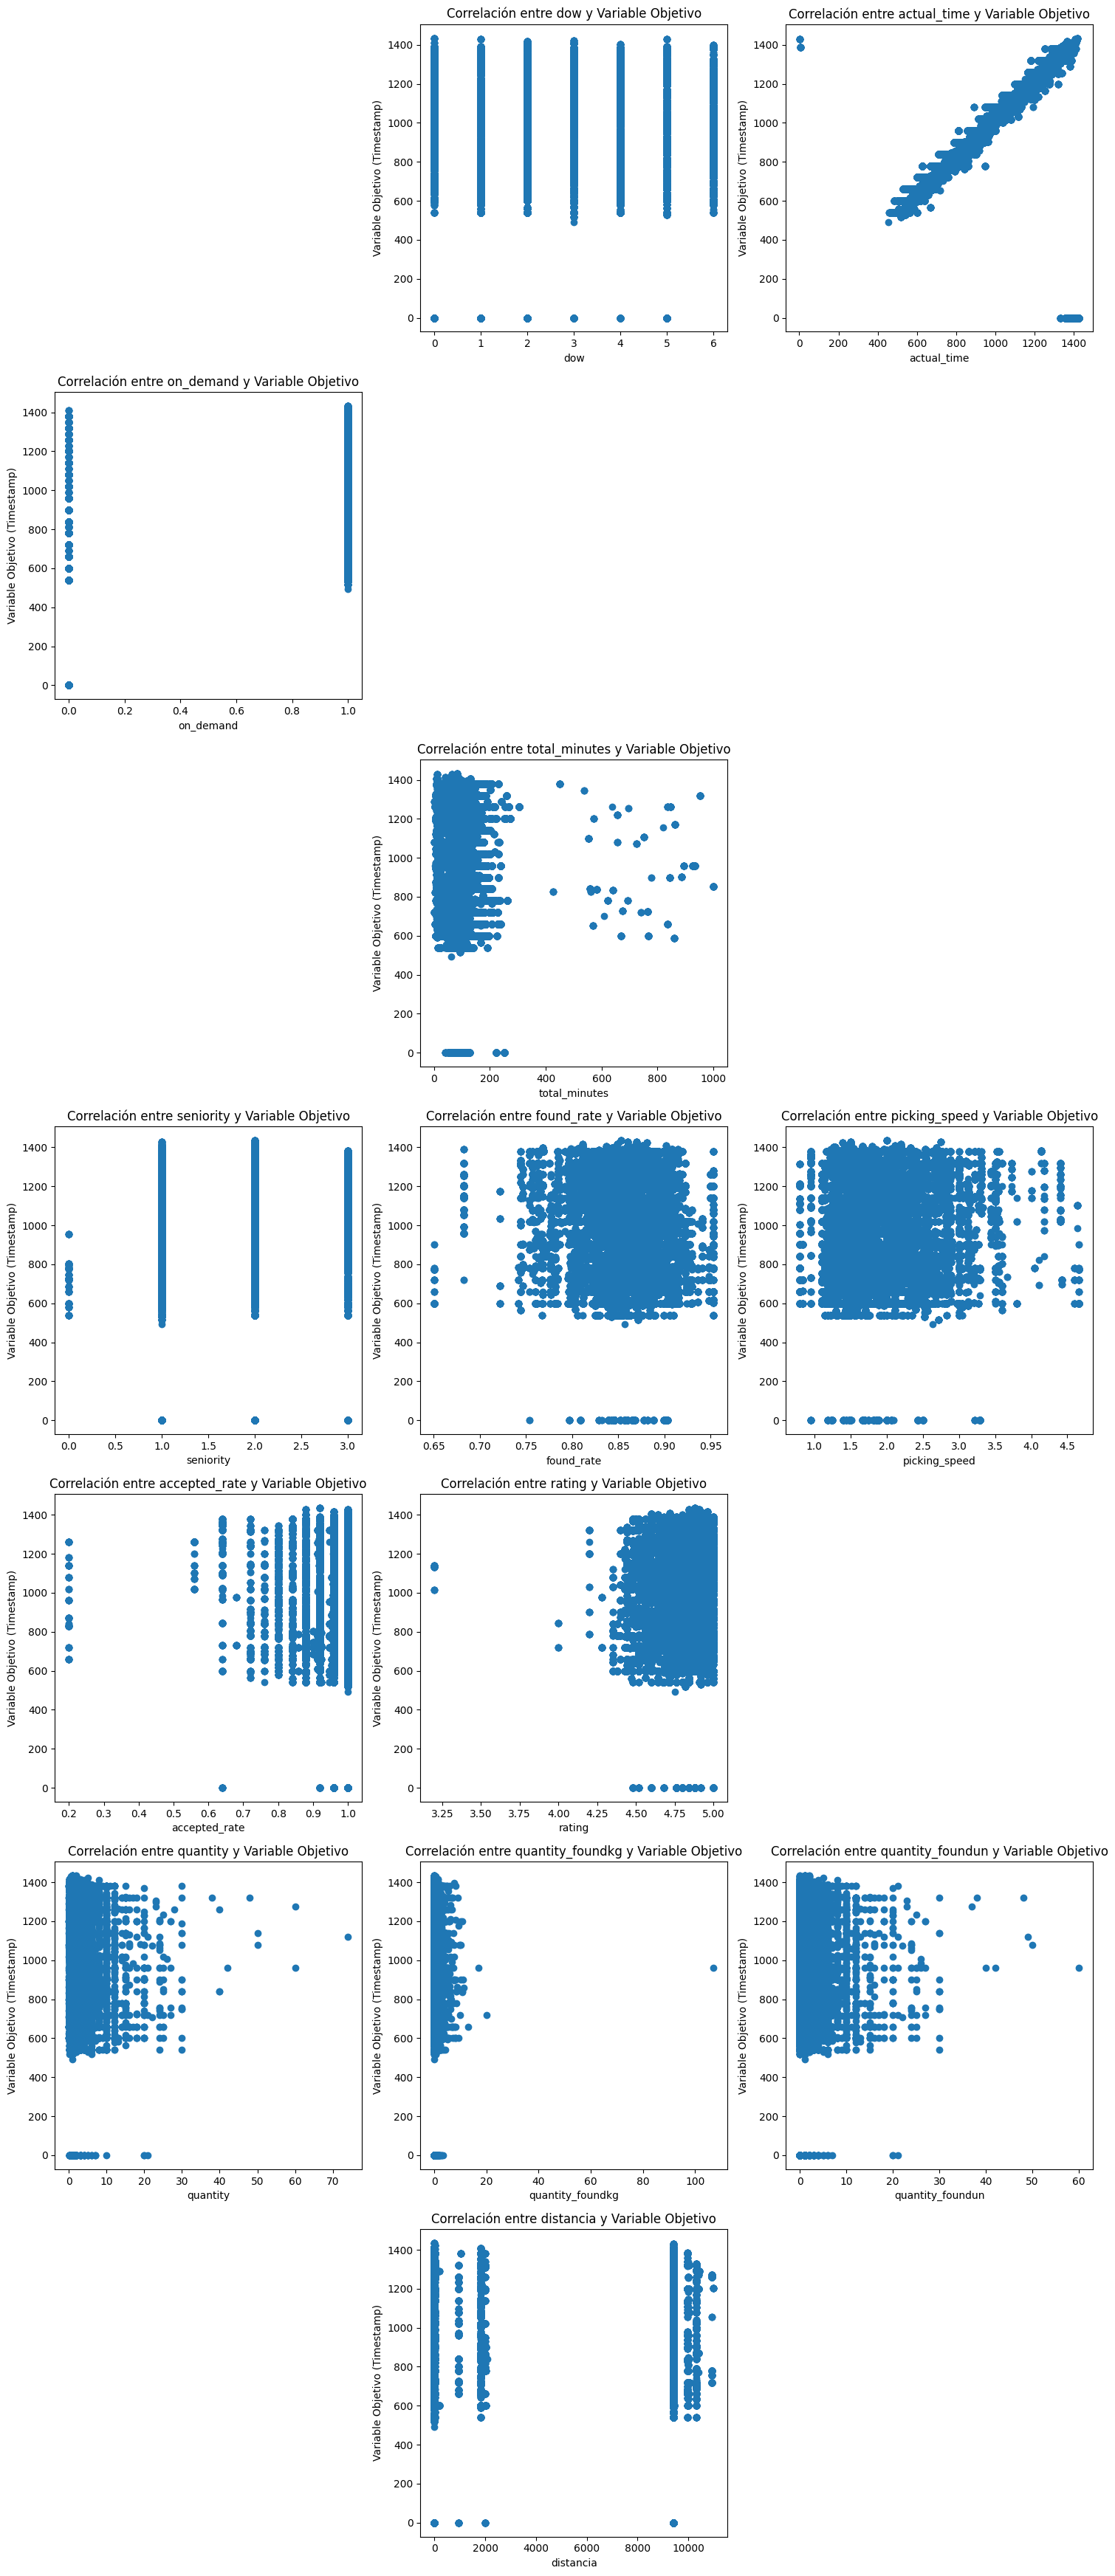

In [104]:



variables_independientes = df_merge.drop('promised_time', axis=1)
n = len(variables_independientes.columns)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows*5))


axes = axes.ravel()

for i, column in enumerate(variables_independientes.columns):

    if np.issubdtype(variables_independientes[column].dtype, np.number):
        axes[i].scatter(variables_independientes[column], df_merge['promised_time'])
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Variable Objetivo (Timestamp)')
        axes[i].set_title(f'Correlación entre {column} y Variable Objetivo')
    else:
        fig.delaxes(axes[i])


if len(variables_independientes.columns) < len(axes):
    for j in range(len(variables_independientes.columns), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


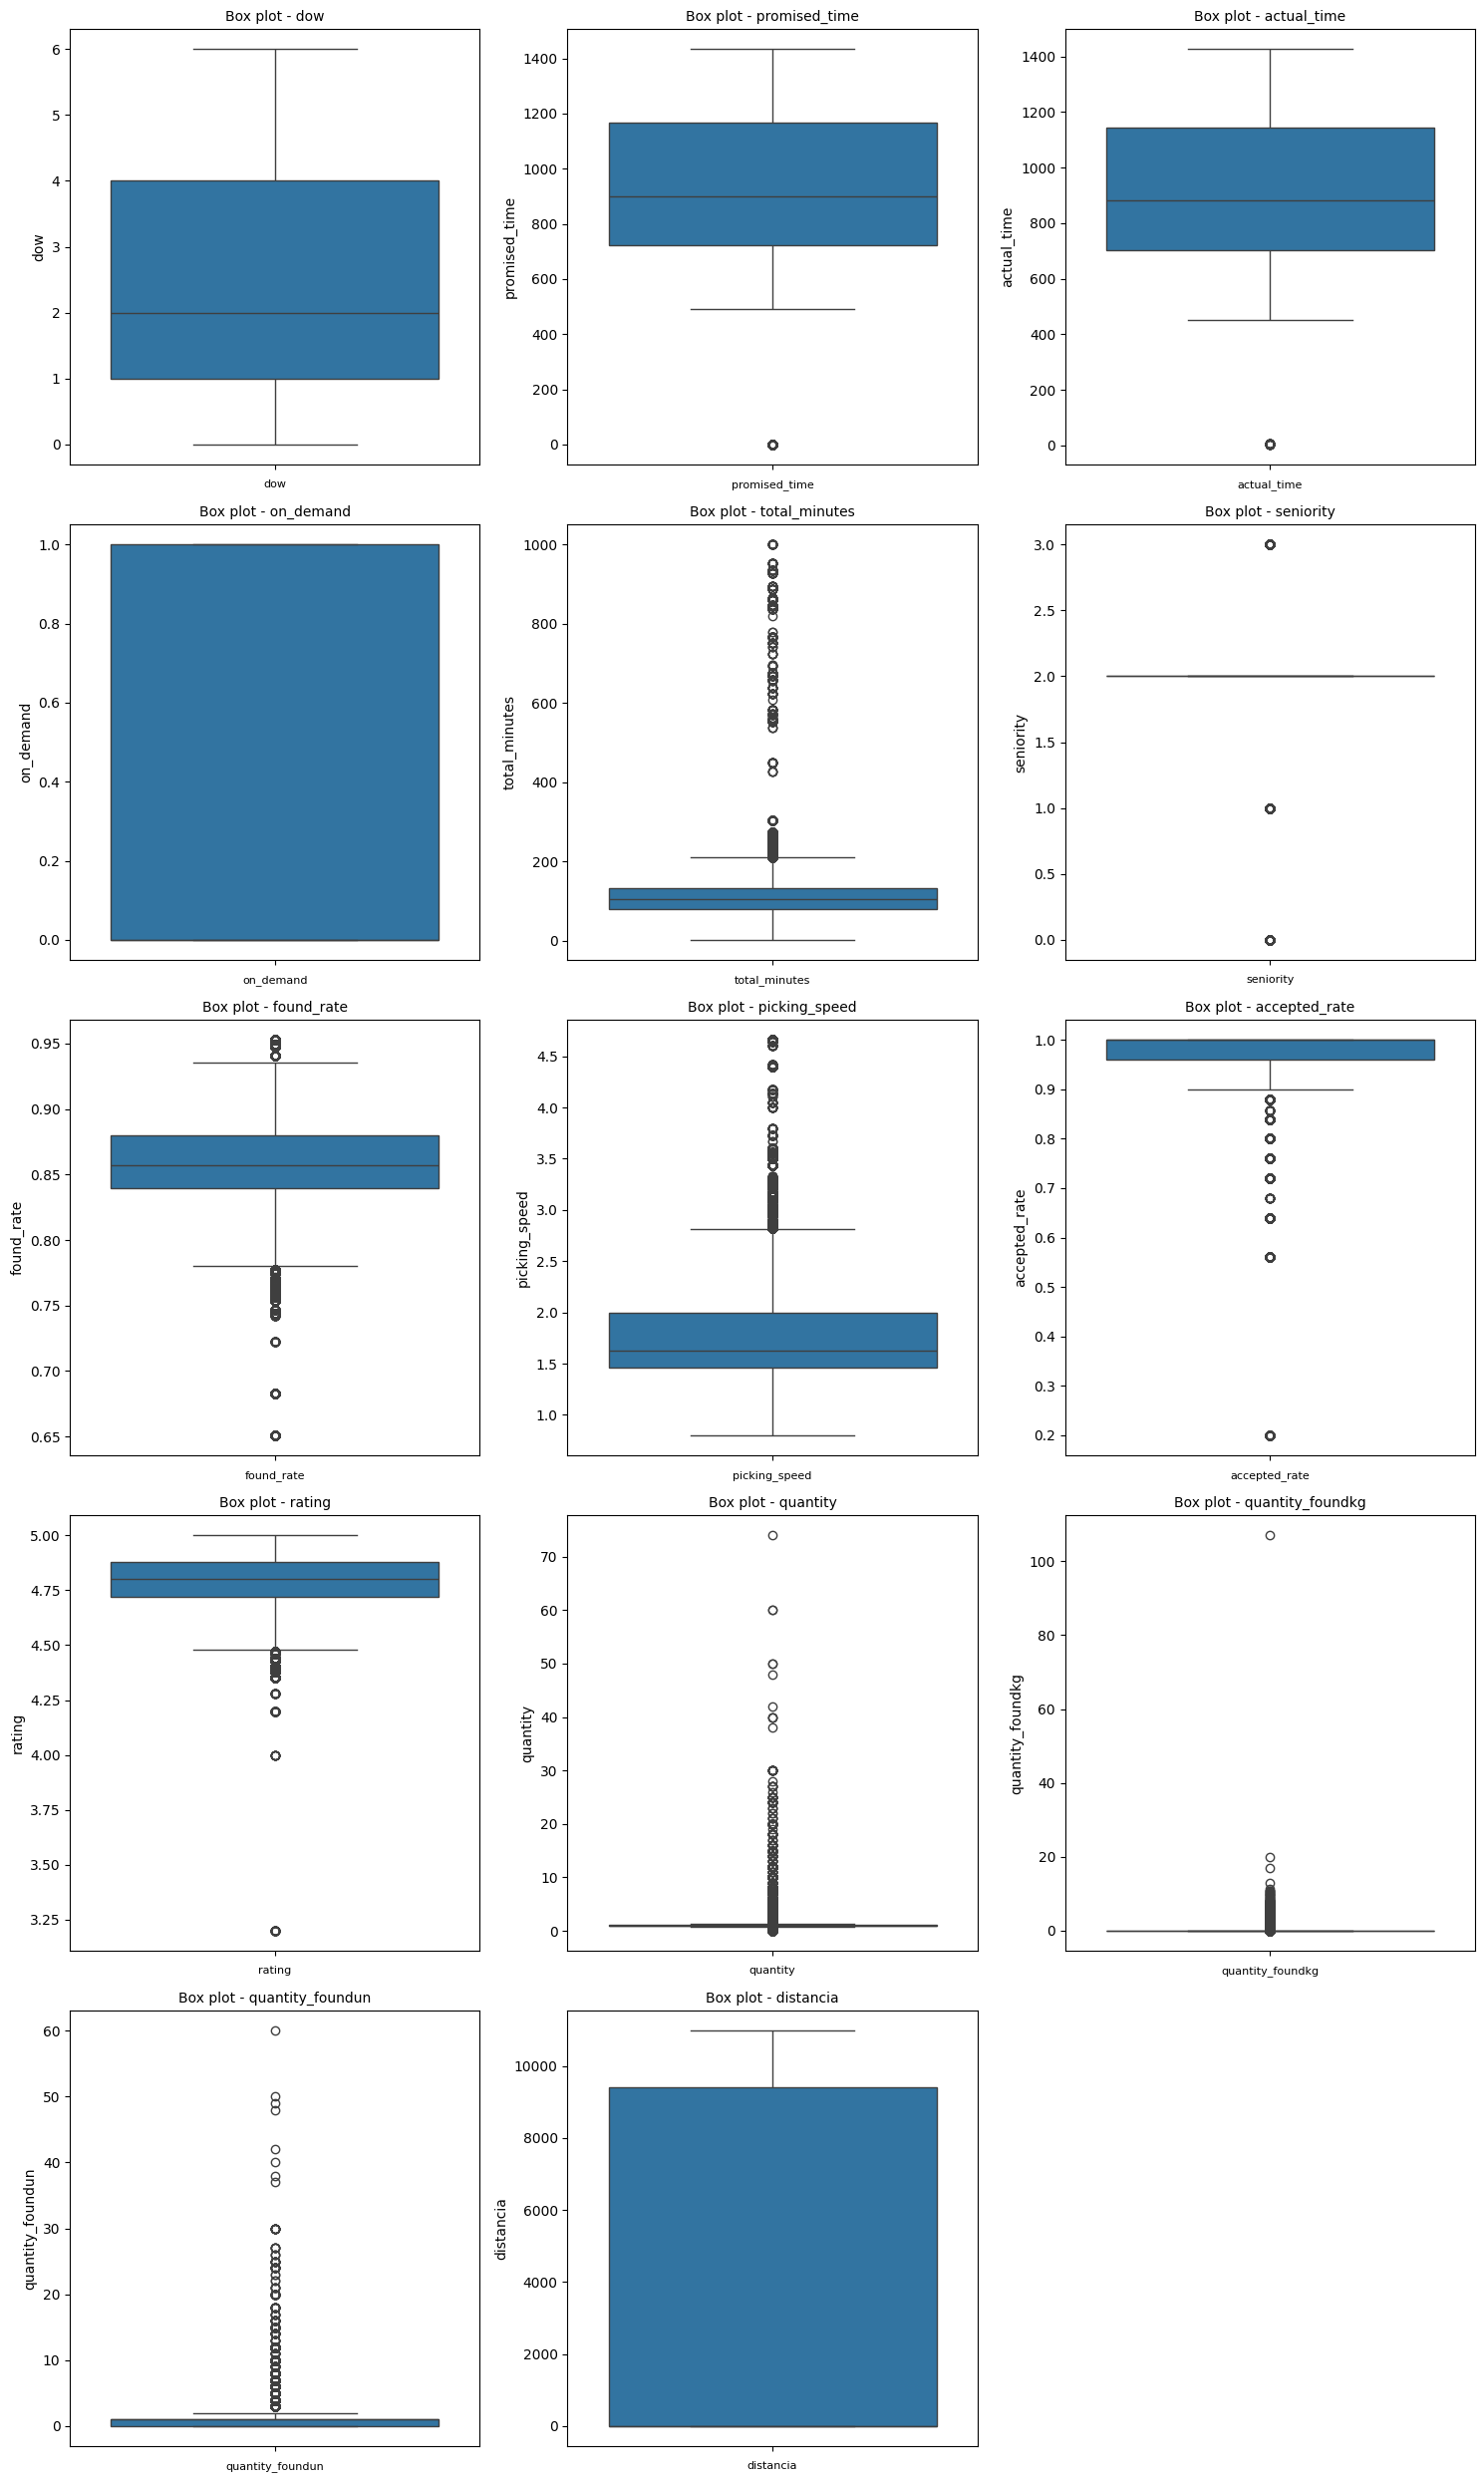

In [105]:
numeric_cols = df_merge.select_dtypes(include=[np.number]).columns.tolist()

n = len(numeric_cols)
ncols = 3
nrows = math.ceil(n / ncols)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5*nrows))


ax = ax.ravel()

for i, num_var in enumerate(numeric_cols):
    sns.boxplot(y=df_merge[num_var], ax=ax[i])
    ax[i].set_title('Box plot - {}'.format(num_var), fontsize=10)
    ax[i].set_xlabel(num_var, fontsize=8)


if n % ncols != 0:
    for j in range(n, nrows*ncols):
        fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

## Test de normalidad

In [106]:
numeric_columns = [  'dow', 'promised_time', 'actual_time', 'on_demand', 'total_minutes', 'seniority', 'found_rate', 'picking_speed', 'accepted_rate', 'rating', 'quantity', 'distancia']


for col in numeric_columns:
    data = df_merge[col].dropna()
    statistic, p_value = stats.shapiro(data)
    print(f'{col}:')
    print(f'  Estadística de Shapiro-Wilk: {statistic}')
    print(f'  p-value: {p_value}\n')

    if p_value < 0.05:
        print("Los datos no provienen de una distribución normal")
    else:
        print("Los datos provienen de una distribución normal")

dow:
  Estadística de Shapiro-Wilk: 0.9378895163536072
  p-value: 0.0

Los datos no provienen de una distribución normal
promised_time:
  Estadística de Shapiro-Wilk: 0.947485089302063
  p-value: 0.0

Los datos no provienen de una distribución normal
actual_time:
  Estadística de Shapiro-Wilk: 0.9497385025024414
  p-value: 0.0

Los datos no provienen de una distribución normal
on_demand:
  Estadística de Shapiro-Wilk: 0.5741005539894104
  p-value: 0.0

Los datos no provienen de una distribución normal
total_minutes:
  Estadística de Shapiro-Wilk: 0.6994078159332275
  p-value: 0.0

Los datos no provienen de una distribución normal
seniority:
  Estadística de Shapiro-Wilk: 0.7279052734375
  p-value: 0.0

Los datos no provienen de una distribución normal
found_rate:
  Estadística de Shapiro-Wilk: 0.9515535831451416
  p-value: 0.0

Los datos no provienen de una distribución normal
picking_speed:
  Estadística de Shapiro-Wilk: 0.8863444924354553
  p-value: 0.0

Los datos no provienen de una

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


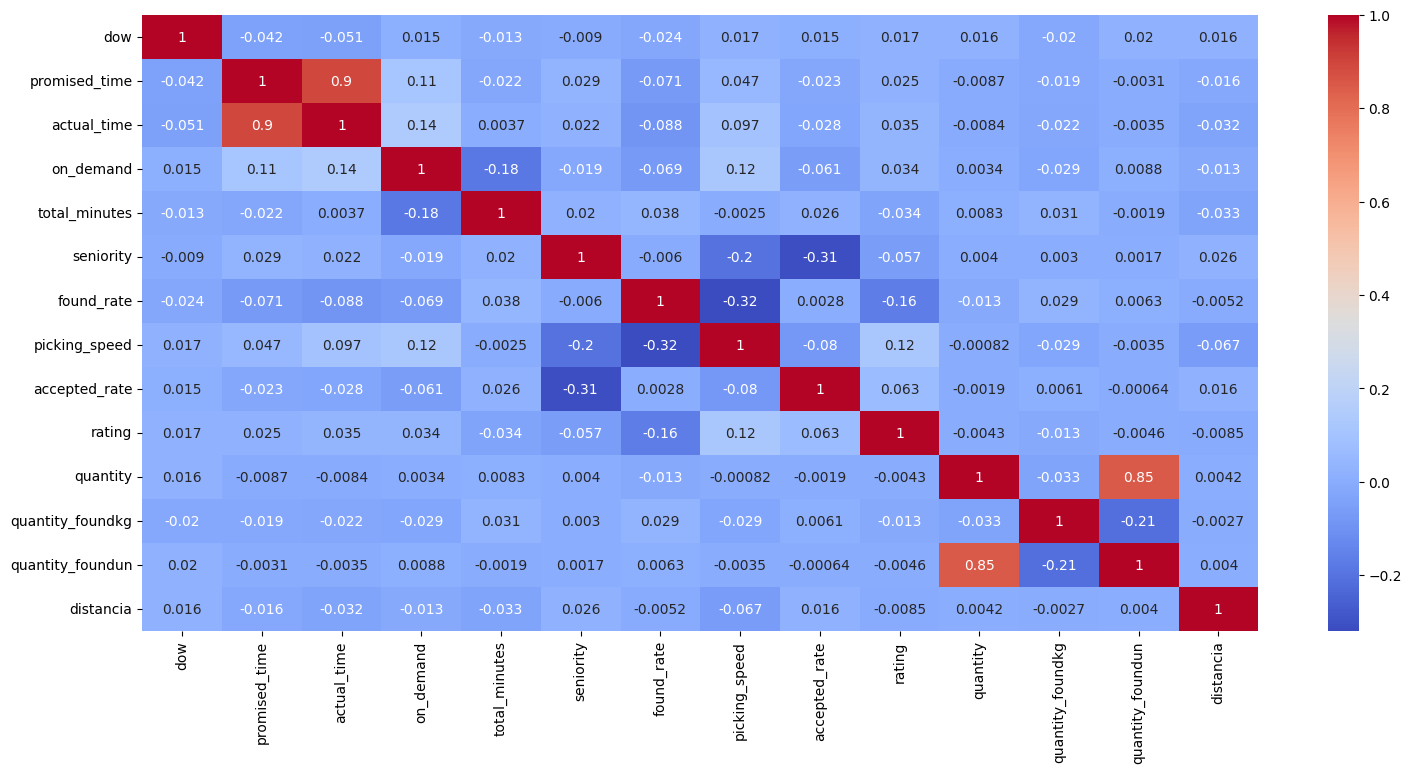

In [107]:
df_numeric = df_merge.select_dtypes(include=[np.number])
corr_matrix = df_numeric.corr()
plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()

# 4_Modelos

Como comente al inicio del trabajo, se evalua distintos modelos para poder predecir la variable 'total_minutes' la cual es la variable objetivo.
Para ello se utiliza el siguiente set de modelos utilizando el análisis de importancia para ver las características más influyentes por cada modelo e ir depurando en un modelo que dependa de menos variables y así de identificar las más importantes e influyentes del modelo.

los modelos son:

1) Random Forest

2) Arboles de decision

3) GAM

### A) test Análisis que incluye las características categóricas
Prediciendo total_minutes: ¿Por qué predecir total_minutes? porque ésto predice el tiempo total que tarda una entrega.

In [159]:
col_drop = ['order_id', 'product_id', 'quantity', 'promised_time', 'dow', 'actual_time']
df_merge_clean = df_merge.drop(col_drop, axis=1)
columnas = ['picker_id', 'driver_id', 'store_branch_id', 'store', 'shopper_id']
df_encoded = pd.get_dummies(df_merge_clean, columns=columnas)
df_encoded

,on_demand,total_minutes,seniority,found_rate,picking_speed,accepted_rate,rating,quantity_foundkg,quantity_foundun,distancia,...,shopper_id_fa685607a6b08125079bd272167da560,shopper_id_faac3cbb015c4e5a32cbbc6a6508d921,shopper_id_fbef0f26f0a5bdc5dc7fd16aefc20f26,shopper_id_fc2f679a0856504a198218e607e8e38d,shopper_id_fc61cb3dbcab6105248875816e269e06,shopper_id_fcdf89d67adaeec14947fed659d1e2c8,shopper_id_fe01b411d1f76e85272f90e6793da293,shopper_id_fe7942861b1933ec95be667458ec73c0,shopper_id_ff33b458218eae5cb41f000e68a1e1a3,shopper_id_ff450da091a3209fbbcd4ed2bd44e355
0,0,104.347683,2.0,0.8564,1.56,1.0,4.68,0.000,1.0,9411.859589,...,False,False,False,False,False,False,False,False,False,False
1,0,104.347683,2.0,0.8564,1.56,1.0,4.68,0.000,3.0,9411.859589,...,False,False,False,False,False,False,False,False,False,False
2,0,104.347683,2.0,0.8564,1.56,1.0,4.68,0.000,1.0,9411.859589,...,False,False,False,False,False,False,False,False,False,False
3,0,104.347683,2.0,0.8564,1.56,1.0,4.68,0.000,1.0,9411.859589,...,False,False,False,False,False,False,False,False,False,False
4,0,104.347683,2.0,0.8564,1.56,1.0,4.68,0.415,0.0,9411.859589,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108767,0,91.843867,2.0,0.8411,1.81,1.0,4.84,0.000,1.0,2.227052,...,False,False,False,False,False,False,False,False,False,False
108768,0,91.843867,2.0,0.8411,1.81,1.0,4.84,0.000,1.0,2.227052,...,False,False,False,False,False,False,False,False,False,False
108769,0,91.843867,2.0,0.8411,1.81,1.0,4.84,0.000,2.0,2.227052,...,False,False,False,False,False,False,False,False,False,False
108770,0,91.843867,2.0,0.8411,1.81,1.0,4.84,0.000,1.0,2.227052,...,False,False,False,False,False,False,False,False,False,False


## A) Variables categoricas


en teoría no deberían ser relevantes e influyentes en algún modelo al ser id's de identificación y autogeneradas probablemente,

### Modelo 1 ) Random Forest

In [158]:
RF_categorico = {}

In [110]:

def random_forest_regression_analysis(df_merge, col_drop, target_column, iteration, show_plot=False, previous_results=None):
    X = df_merge.drop(col_drop, axis=1)
    y = df_merge[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    modelRN = RandomForestRegressor(n_estimators=100, random_state=42)
    modelRN.fit(X_train, y_train)
    predictions = modelRN.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    mae = median_absolute_error(y_test, predictions)
    r2_ = r2_score(y_test, predictions)

    results_dict = {'MSE': mse, 'MAE': mae, 'R^2': r2_}

    importances = modelRN.feature_importances_
    feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)

    if show_plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        plt.bar(feature_importances['feature'], feature_importances['importance'])
        plt.xticks(rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title('Feature Importances Random Forest')
        plt.tight_layout()
        plt.show()

    iteration_label = f'iteracion{iteration}'
    results_df = pd.DataFrame(results_dict, index=[iteration_label])

    random_forest_results = {
        'X_test': X_test,
        'modelRN': modelRN,
        'X_train': X_train,
        'predictions': predictions,
        'y_train': y_train,
        'y_test': y_test,
        'feature_importances' : feature_importances,
        'results_df': results_df
    }

    if previous_results is not None:
        previous_results[iteration_label] = random_forest_results
    else:
        previous_results = {iteration_label: random_forest_results}

    return previous_results


In [160]:

col_drop = ["total_minutes"]
# Primera iteración
RF_categorico = random_forest_regression_analysis(df_encoded, col_drop, 'total_minutes', iteration=1, show_plot=False, previous_results=RF_categorico)

In [161]:
RF_categorico["iteracion1"]["results_df"]


,MSE,MAE,R^2
iteracion1,28.702799,1.421085e-13,0.993054


In [162]:
RF_categorico["iteracion1"]["feature_importances"]

,feature,importance
8,distancia,3.673620e-01
2,found_rate,3.922881e-02
3,picking_speed,3.659376e-02
0,on_demand,3.499640e-02
5,rating,2.104458e-02
...,...,...
459,picker_id_d339580fa5d4ce97bda7a3f3b37c3209,6.137008e-09
215,picker_id_63d3b72c2ebccd721fa0b28fa6fe6448,5.193489e-09
412,picker_id_b9470234705d6091d5131757d7f52f3f,5.180747e-10
1218,store_branch_id_d63b1919fe2cf76f494521dfa4389488,0.000000e+00


### Modelo 2 ) Arboles de decision


In [114]:
DT_categorico = {}

In [115]:
def decision_tree_regression_analysis(df_merge, col_drop, target_column, iteration, show_plot=False, previous_results=None):
    X = df_merge.drop(col_drop, axis=1)
    y = df_merge[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    modelDT = DecisionTreeRegressor(random_state=42)
    modelDT.fit(X_train, y_train)
    predictions = modelDT.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    mae = median_absolute_error(y_test, predictions)
    r2_ = r2_score(y_test, predictions)

    results_dict = {'MSE': mse, 'MAE': mae, 'R^2': r2_}

    importances = modelDT.feature_importances_
    feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)

    if show_plot:
        plt.figure(figsize=(10, 6))
        plt.bar(feature_importances['feature'], feature_importances['importance'])
        plt.xticks(rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title('Feature Importances Decision Tree')
        plt.tight_layout()
        plt.show()

    iteration_label = f'iteracion{iteration}'
    results_df = pd.DataFrame(results_dict, index=[iteration_label])

    if previous_results is not None:
        previous_results[iteration_label] = {
            'modelDT': modelDT,
            'X_test': X_test,
            'predictions': predictions,
            'results_df': results_df,
             'feature_importances' : feature_importances,
        }
    else:
        previous_results = {iteration_label: {
            'modelDT': modelDT,
            'X_test': X_test,
            'predictions': predictions,
            'results_df': results_df,
             'feature_importances' : feature_importances,
        }}

    return previous_results






In [116]:
col_drop = ['total_minutes']
# Primera iteración
DT_categorico = decision_tree_regression_analysis(df_encoded, col_drop, 'total_minutes', iteration=1, show_plot=False, previous_results=DT_categorico)

In [117]:
DT_categorico["iteracion1"]["results_df"]


,MSE,MAE,R^2
iteracion1,24.023998,7.105427e-15,0.994187


In [118]:
DT_categorico["iteracion1"]["feature_importances"]

,feature,importance
8,distancia,0.384353
3,picking_speed,0.037674
0,on_demand,0.035100
2,found_rate,0.033221
1236,store_451eb58b96f0a36f31d2beebd1c9a7a8,0.021191
...,...,...
1302,shopper_id_18f215429792310636b68fde491b5d52,0.000000
746,driver_id_58debf4ad089ead934fc5b575fbb84b5,0.000000
1305,shopper_id_19490e74c169541b48ce50330477b772,0.000000
125,picker_id_35deb2375f79baaf8ff65b7d6be7349a,0.000000


### Modelo 3 ) GAM

In [119]:
GAM_categorico = {}
def gam_regression_analysis(df_merge, col_drop, target_column, iteration, show_plot=False, previous_results=None):
    # Preparación de los datos
    X = df_merge.drop(col_drop, axis=1)
    y = df_merge[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # Construcción del modelo GAM
    terms = sum((s(i) for i in range(X_train.shape[1])), s(0))
    gam = LinearGAM(terms).gridsearch(X_train.values, y_train.values)

    # Predicciones y métricas de evaluación
    predictions = gam.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = median_absolute_error(y_test, predictions)
    r2_ = r2_score(y_test, predictions)

    # Cálculo de importancia de características
    results = permutation_importance(gam, X_test, y_test, scoring='neg_mean_squared_error')
    importance = results.importances_mean
    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importance})
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)

    # Visualización de la importancia de las características
    if show_plot:
        plt.figure(figsize=(10, 6))
        plt.bar(feature_importances['feature'], feature_importances['importance'])
        plt.xticks(rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title('Feature Importances GAM')
        plt.tight_layout()
        plt.show()

    # Visualización de las dependencias parciales
    n_cols = 3
    n_rows = math.ceil(len(X_train.columns) / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*5))

    non_intercept_terms = [i for i, term in enumerate(gam.terms) if not term.isintercept]
    for i, ax in enumerate(axs.flatten()):
        if i < len(non_intercept_terms):
            term_idx = non_intercept_terms[i]
            XX = gam.generate_X_grid(term=term_idx)

            title = X_train.columns[i]

            ax.plot(XX[:, term_idx], gam.partial_dependence(term=term_idx, X=XX))
            ax.plot(XX[:, term_idx], gam.partial_dependence(term=term_idx, X=XX, width=.95)[1], c='r', ls='--')

            ax.scatter(X_train[title], [0]*len(X_train[title]), marker='|', alpha=.5)

            ax.set_title(title)
        else:
            fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

    # Almacenamiento de resultados
    iteration_label = f'iteracion{iteration}'
    results_dict = {'MSE': mse, 'MAE': mae, 'R^2': r2_}
    results_df = pd.DataFrame(results_dict, index=[iteration_label])

    if previous_results is not None:
        previous_results[iteration_label] = {
            'gam': gam,
            'X_test': X_test,
            'predictions': predictions,
            'results_df': results_df,
            'feature_importances': feature_importances
        }
    else:
        previous_results = {iteration_label: {
            'gam': gam,
            'X_test': X_test,
            'predictions': predictions,
            'results_df': results_df,
            'feature_importances': feature_importances
        }}

    return previous_results

In [120]:
GAM_categorico = decision_tree_regression_analysis(df_encoded, col_drop, 'total_minutes', iteration=1, show_plot=False, previous_results=GAM_categorico)

In [121]:
GAM_categorico["iteracion1"]["results_df"]

,MSE,MAE,R^2
iteracion1,24.023998,7.105427e-15,0.994187


In [122]:
GAM_categorico["iteracion1"]["feature_importances"]

,feature,importance
8,distancia,0.384353
3,picking_speed,0.037674
0,on_demand,0.035100
2,found_rate,0.033221
1236,store_451eb58b96f0a36f31d2beebd1c9a7a8,0.021191
...,...,...
1302,shopper_id_18f215429792310636b68fde491b5d52,0.000000
746,driver_id_58debf4ad089ead934fc5b575fbb84b5,0.000000
1305,shopper_id_19490e74c169541b48ce50330477b772,0.000000
125,picker_id_35deb2375f79baaf8ff65b7d6be7349a,0.000000


## Comentarios variables categoricas
Dados los resultados anteriores con las variables categóricas, **se opta por trabajar solamente con las numéricas descartando toda importancia de las variables categóricas en la predicción del vector objetivo**, se observa un MSE muy bajo , lo que indica que las predicciones del modelo tienen una diferencia muy pequeña con los valores reales. El MAE también es extremadamente bajo, cercano a cero, lo que sugiere que las predicciones tienen una diferencia promedio muy pequeña en términos absolutos. Además, el valor de R^2 es alto (aproximadamente 0.994), lo que indica que el modelo es capaz de explicar aproximadamente el 99.4% de la variabilidad de los datos.

## B) Variables numericas

test primer acercamiento

RF_categorico

In [123]:
col_drop = ['promised_time', 'order_id', 'picker_id', 'driver_id', 'store_branch_id', 'shopper_id', 'product_id',
            'store','dow', 'actual_time','total_minutes']
RF_numerico = {}
DT_numerico = {}
GAM_numerico = {}

#### SFS

In [124]:


def sfs(df_merge, col_drop, y_col, show_plot=False,forward_selection=False):
    X = df_merge.drop(col_drop, axis=1)
    y = df_merge[y_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    dt_regressor = DecisionTreeRegressor(random_state=42)
    if forward_selection:
        sfs = SFS(dt_regressor,
                  k_features=(1, len(X.columns)),
                  forward=True,
                  floating=False,
                  scoring='neg_mean_squared_error',
                  cv=5)
    else:
        sfs = SFS(dt_regressor,
                  k_features=(1, len(X.columns)),
                  forward=False,
                  floating=False,
                  scoring='neg_mean_squared_error',
                  cv=5)


    sfs = sfs.fit(X_train, y_train)

    selected_features = list(sfs.k_feature_names_)
    print("Selected features:", selected_features)


In [125]:
sfs(df_merge, col_drop, 'total_minutes', True,True)

Selected features: ['seniority', 'rating', 'distancia']


In [126]:
sfs(df_merge, col_drop, 'total_minutes', True,False)

Selected features: ['rating', 'distancia']


#### PCA

In [127]:
def DecisionTreeRegression_with_PCA(df_merge, col_drop, y_col, n_components=None):
    X = df_merge.drop(col_drop, axis=1)
    y = df_merge[y_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)


    dt_regressor = DecisionTreeRegressor(random_state=42)
    dt_regressor.fit(X_train_pca, y_train)

    y_pred_train = dt_regressor.predict(X_train_pca)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)
    print("pca MAE:", train_mae)
    print("pca R^2:", train_r2)

    y_pred_test = dt_regressor.predict(X_test_pca)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    print("pca MAE:", test_mae)
    print("pca R^2:", test_r2)

    return pca, dt_regressor, train_mae, train_r2, test_mae, test_r2


pca_default, modelDT_pca_default, train_mae_default, train_r2_default, test_mae_default, test_r2_default = DecisionTreeRegression_with_PCA(df_merge, col_drop, 'total_minutes',1)


pca_custom, modelDT_pca_custom, train_mae_custom, train_r2_custom, test_mae_custom, test_r2_custom = DecisionTreeRegression_with_PCA(df_merge, col_drop, 'total_minutes', n_components=2)


pca MAE: 2.5428386609841453
pca R^2: 0.9288428600202994
pca MAE: 2.7792590149600236
pca R^2: 0.9338923062723803
pca MAE: 1.0854107556198596e-14
pca R^2: 1.0
pca MAE: 7.945103908985388
pca R^2: 0.7143743147879129


In [128]:
col_drop = ['promised_time', 'order_id', 'picker_id', 'driver_id', 'store_branch_id', 'shopper_id', 'product_id',
            'store','dow', 'actual_time','total_minutes']

#### Iteracion 1

In [129]:
def estadistica_modelo(dic):
    return pd.concat([result['results_df'] for result in dic.values()])

##### Modelo 1 ) Random Forest

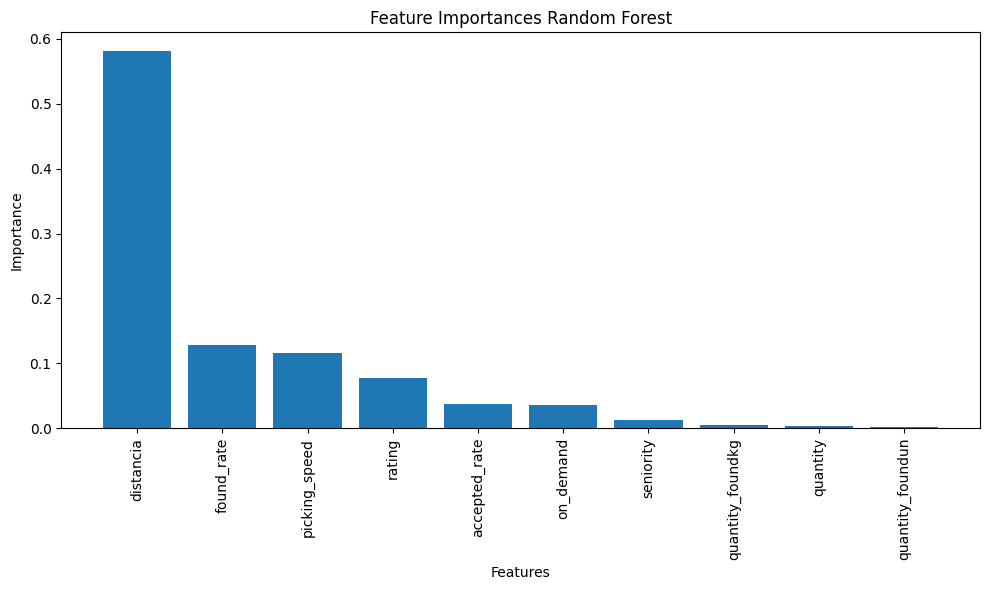

In [130]:
RF_numerico = random_forest_regression_analysis(df_merge, col_drop, 'total_minutes', iteration=1, show_plot=True, previous_results=RF_numerico)

In [131]:
RF_numerico["iteracion1"]["results_df"]

,MSE,MAE,R^2
iteracion1,42.012638,1.705303e-13,0.989834


##### Modelo 2 ) decision tree

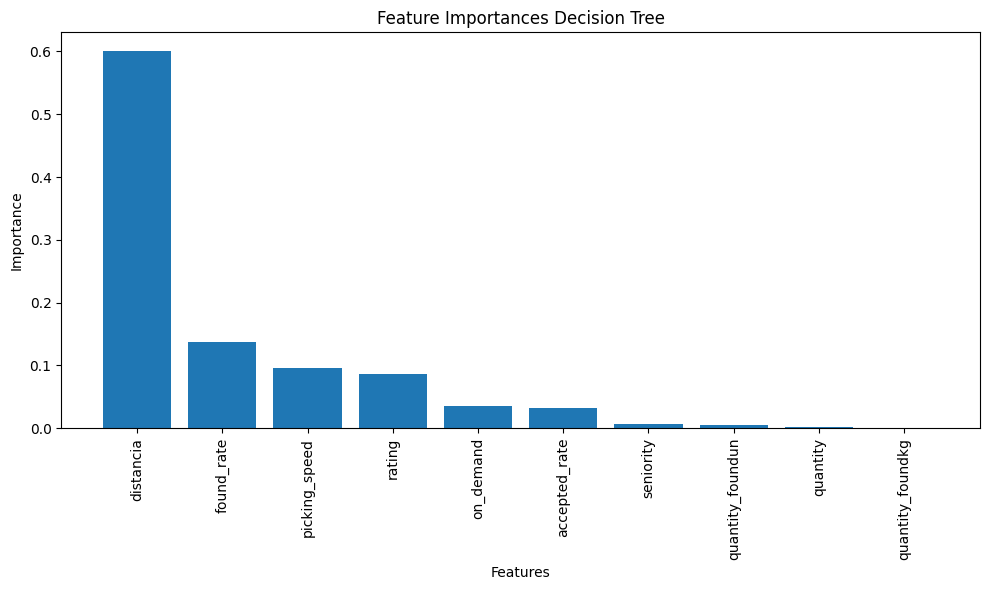

In [132]:
DT_numerico = decision_tree_regression_analysis(df_merge, col_drop, 'total_minutes', iteration=1, show_plot=True, previous_results=DT_numerico)

In [133]:
DT_numerico["iteracion1"]["results_df"]

,MSE,MAE,R^2
iteracion1,93.199697,7.105427e-15,0.977447


##### Modelo 3 ) GAM

100% (11 of 11) |########################| Elapsed Time: 0:01:26 Time:  0:01:26


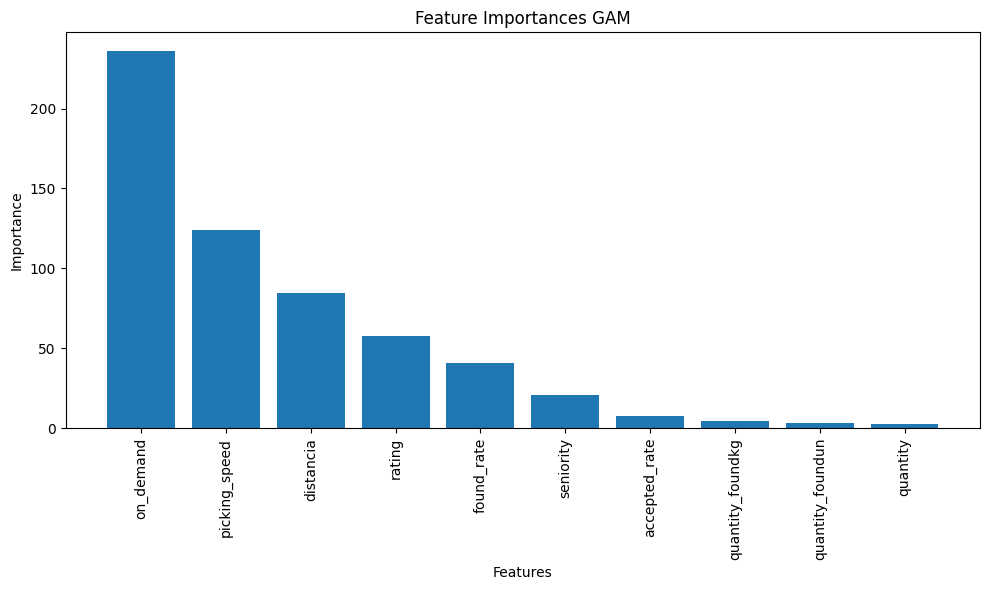

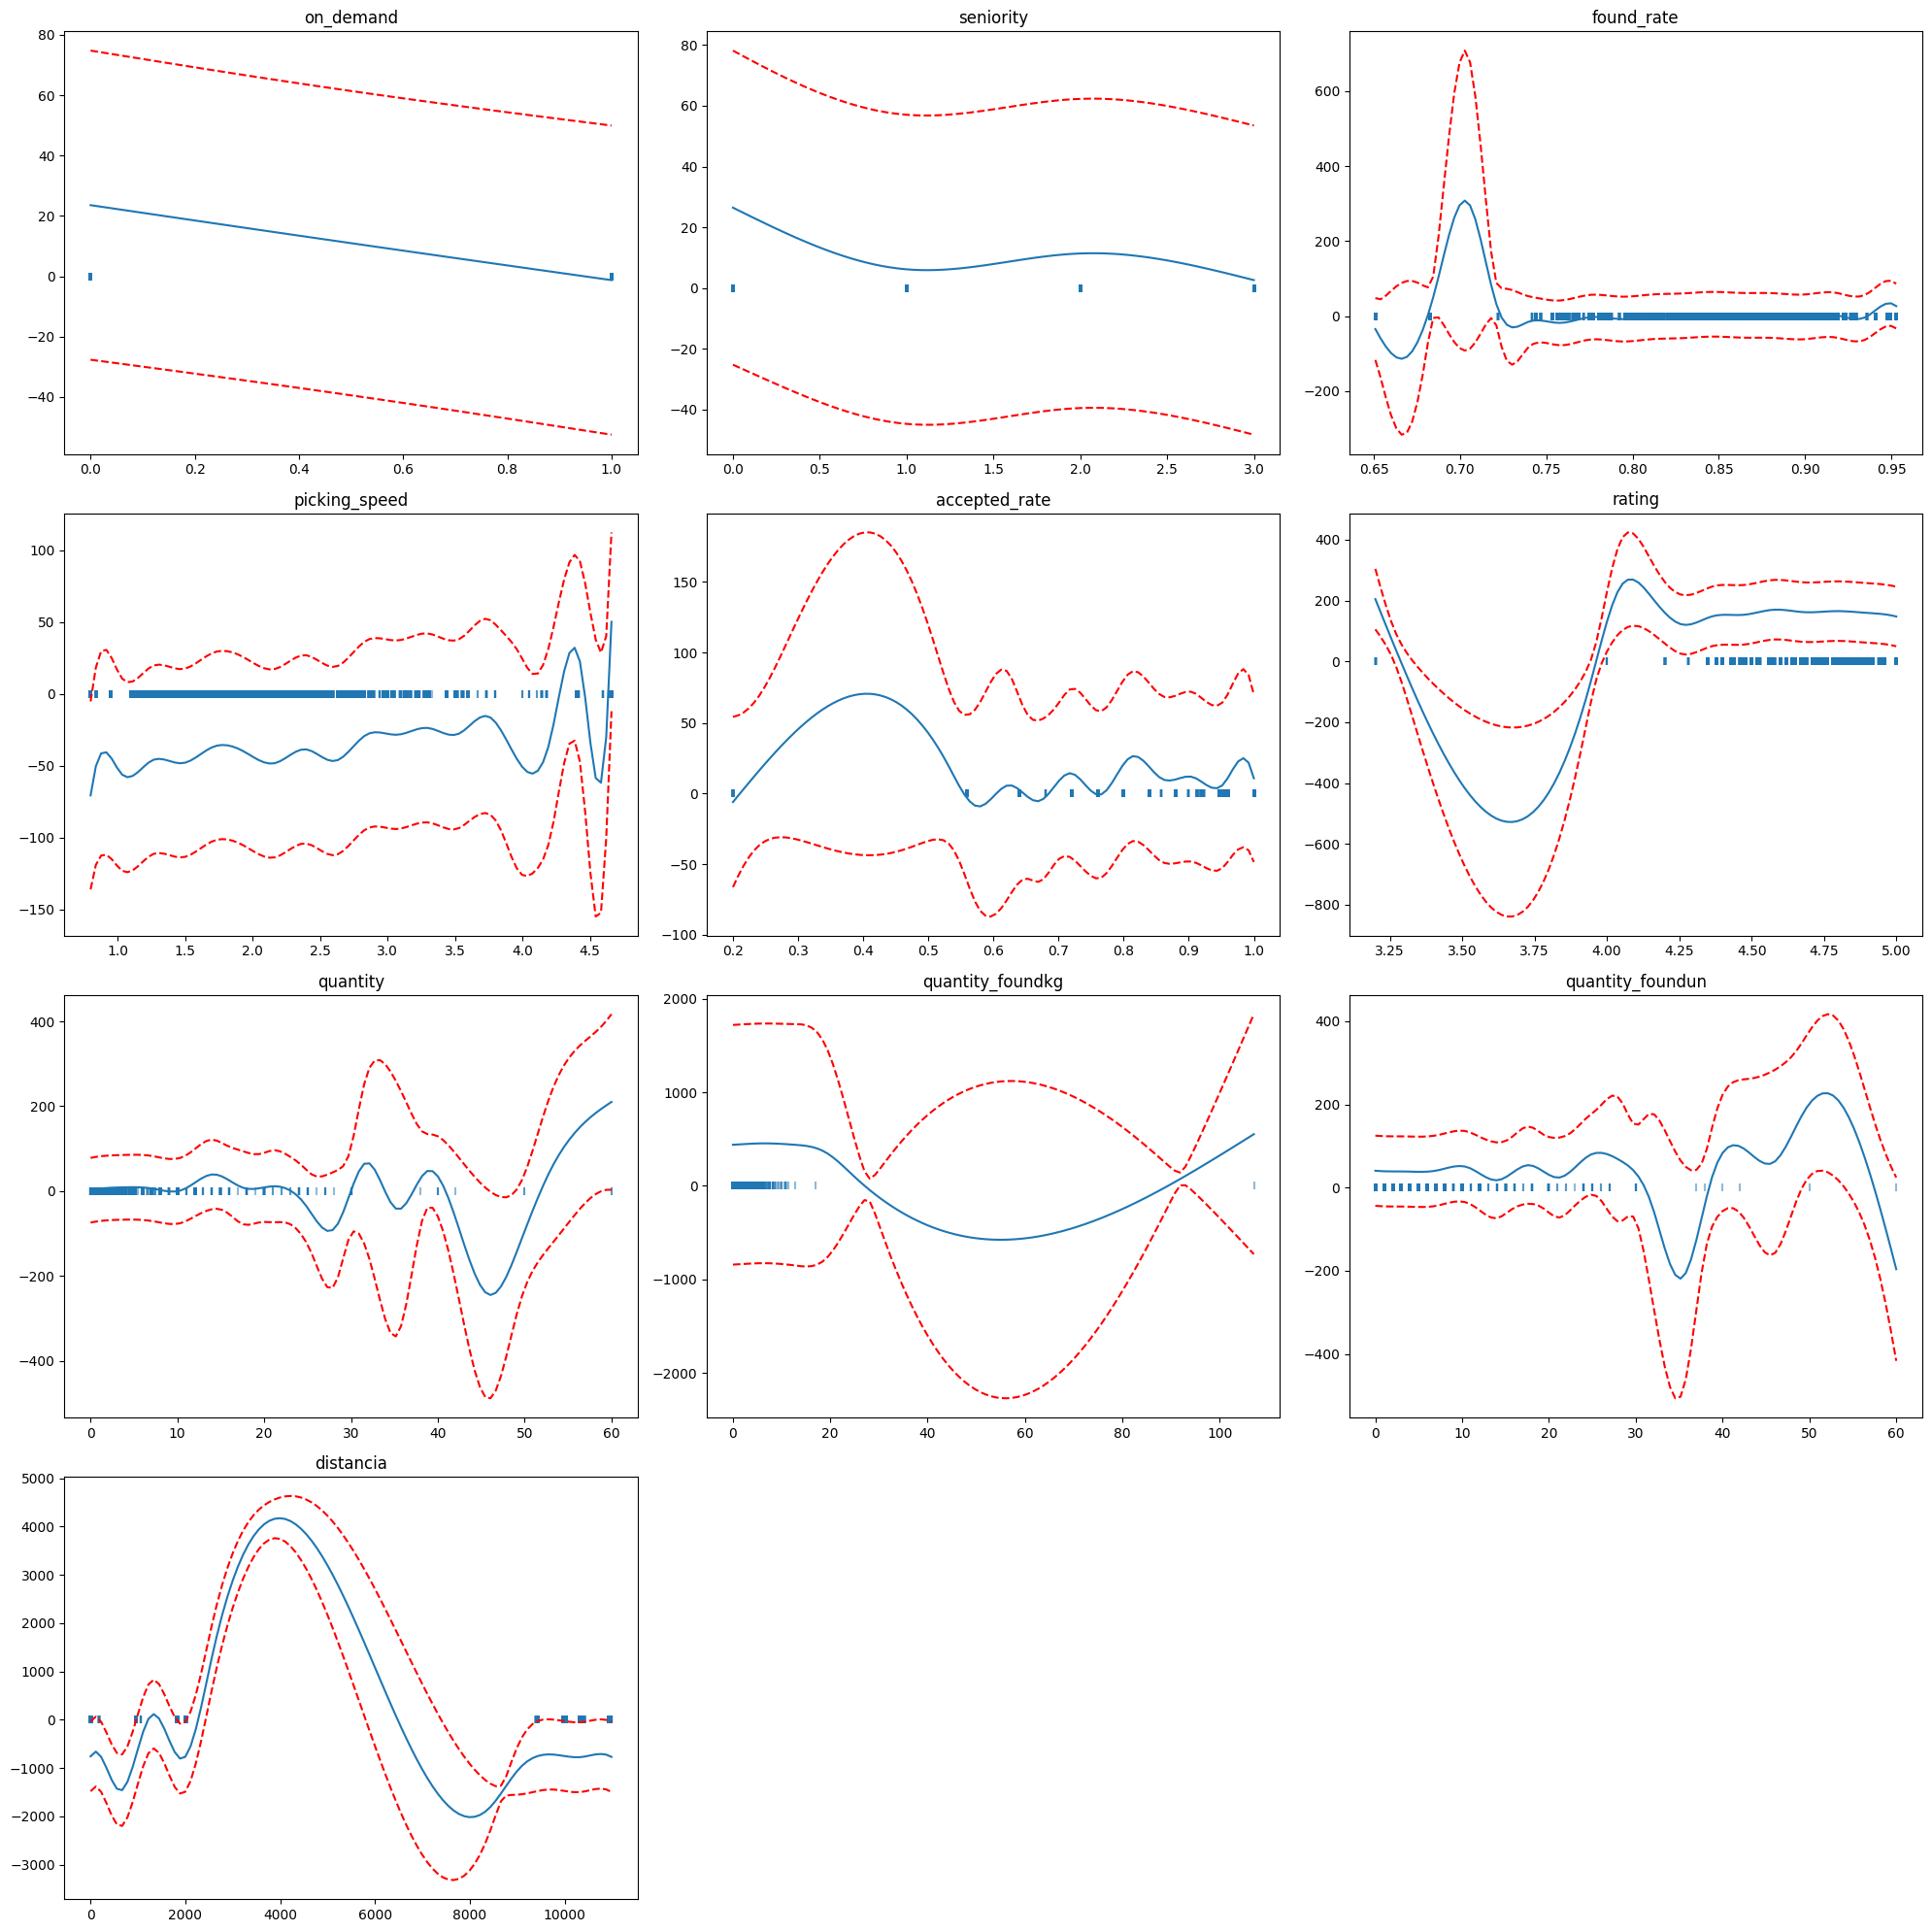

In [134]:
GAM_numerico = gam_regression_analysis(df_merge, col_drop, 'total_minutes', iteration=1, show_plot=True, previous_results=GAM_numerico)

##### Estadistica

In [135]:
RF_numerico["iteracion1"]["results_df"]

,MSE,MAE,R^2
iteracion1,42.012638,1.705303e-13,0.989834


In [136]:
DT_numerico["iteracion1"]["results_df"]

,MSE,MAE,R^2
iteracion1,93.199697,7.105427e-15,0.977447


In [137]:
GAM_numerico["iteracion1"]["results_df"]

,MSE,MAE,R^2
iteracion1,3883.326012,24.972518,0.060291


Es importante tener en cuenta que la presencia de variables irrelevantes o variables con p-valores altos no necesariamente indica que el modelo sea malo en su totalidad. Sin embargo, es posible que estas variables irrelevantes estén introduciendo ruido o multicolinealidad en el modelo, lo que puede afectar su rendimiento y precisión.


#### iteracion 2
**Segunda reducción de variables:**
La idea es ir depurando el modelo en sus variables más significativas para encontrar un modelo que condense las mayores importancias y practicidad al momento de predecir, y viendo el efecto en las métricas del modelo para obtener un modelo que dependa de menos variables.
Eliminaremos para:

1)Random forest: 'seniority', 'quantity_foundkg', 'quantity', 'quantity_foundun'

2)Decision tree: 'seniority', 'quantity_foundkg', 'quantity', 'quantity_foundun'

3) GAM : 'quantity_foundkg', 'quantity', 'quantity_foundun', 'accepted_rate'

In [138]:
# Lista de columnas a eliminar
col_drop = ['promised_time', 'order_id', 'picker_id', 'driver_id', 'store_branch_id', 'shopper_id', 'product_id',
            'store', 'total_minutes', 'dow','actual_time', 'seniority', 'quantity', 'quantity_foundun', 'quantity_foundkg']

##### Modelo 1 ) Random Forest

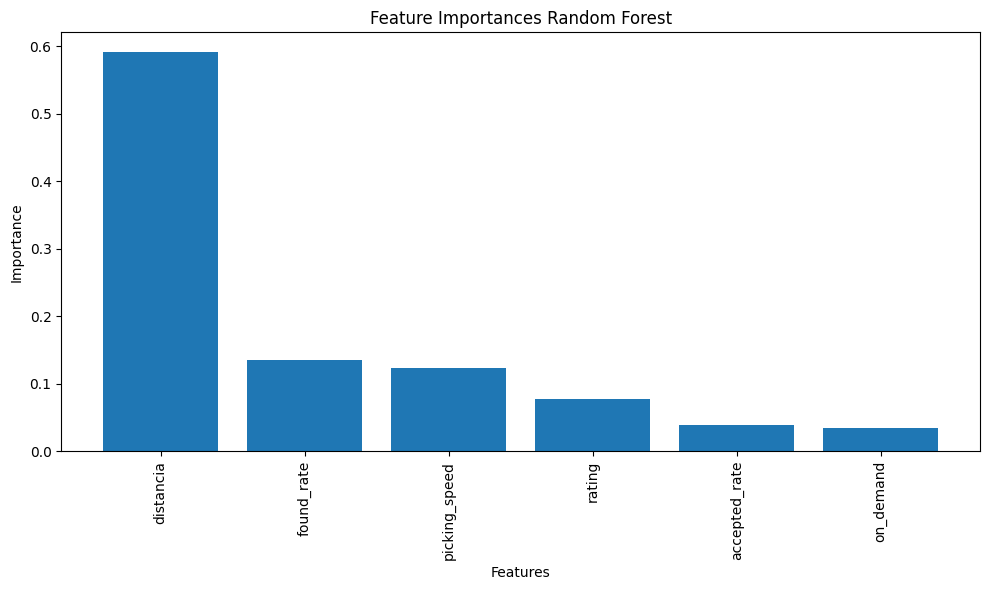

In [139]:
RF_numerico = random_forest_regression_analysis(df_merge, col_drop, 'total_minutes', iteration=2, show_plot=True, previous_results=RF_numerico)

##### Modelo 2 ) Decision tree

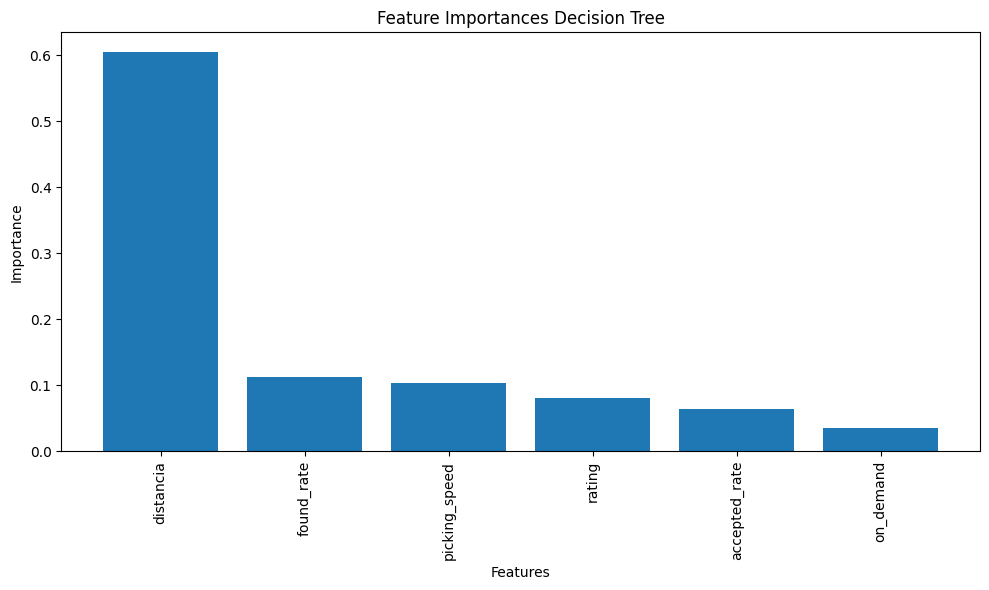

In [140]:
DT_numerico = decision_tree_regression_analysis(df_merge, col_drop, 'total_minutes', iteration=2, show_plot=True, previous_results=DT_numerico)

##### Modelo 3 )GAM


100% (11 of 11) |########################| Elapsed Time: 0:00:53 Time:  0:00:53


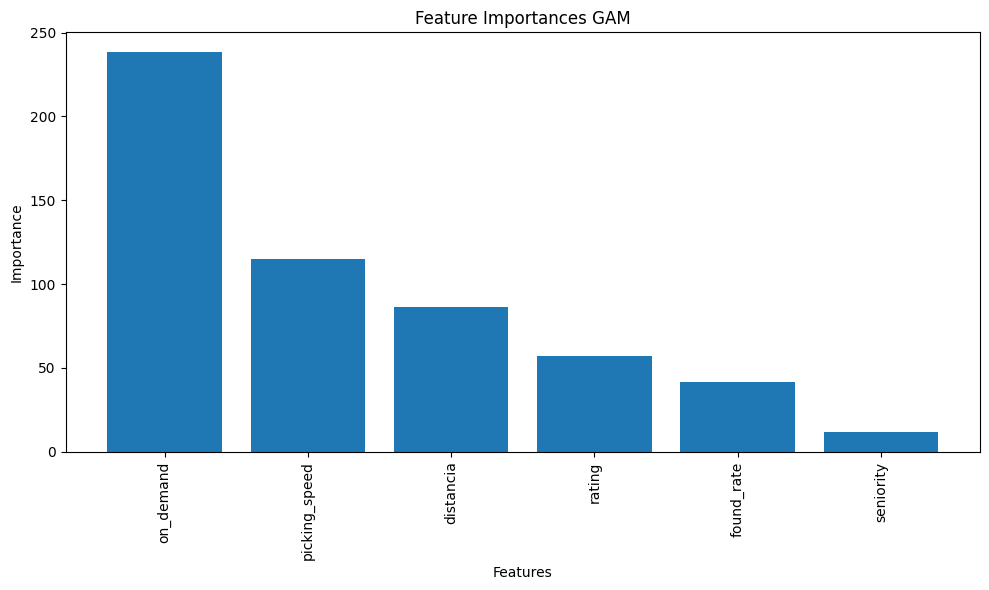

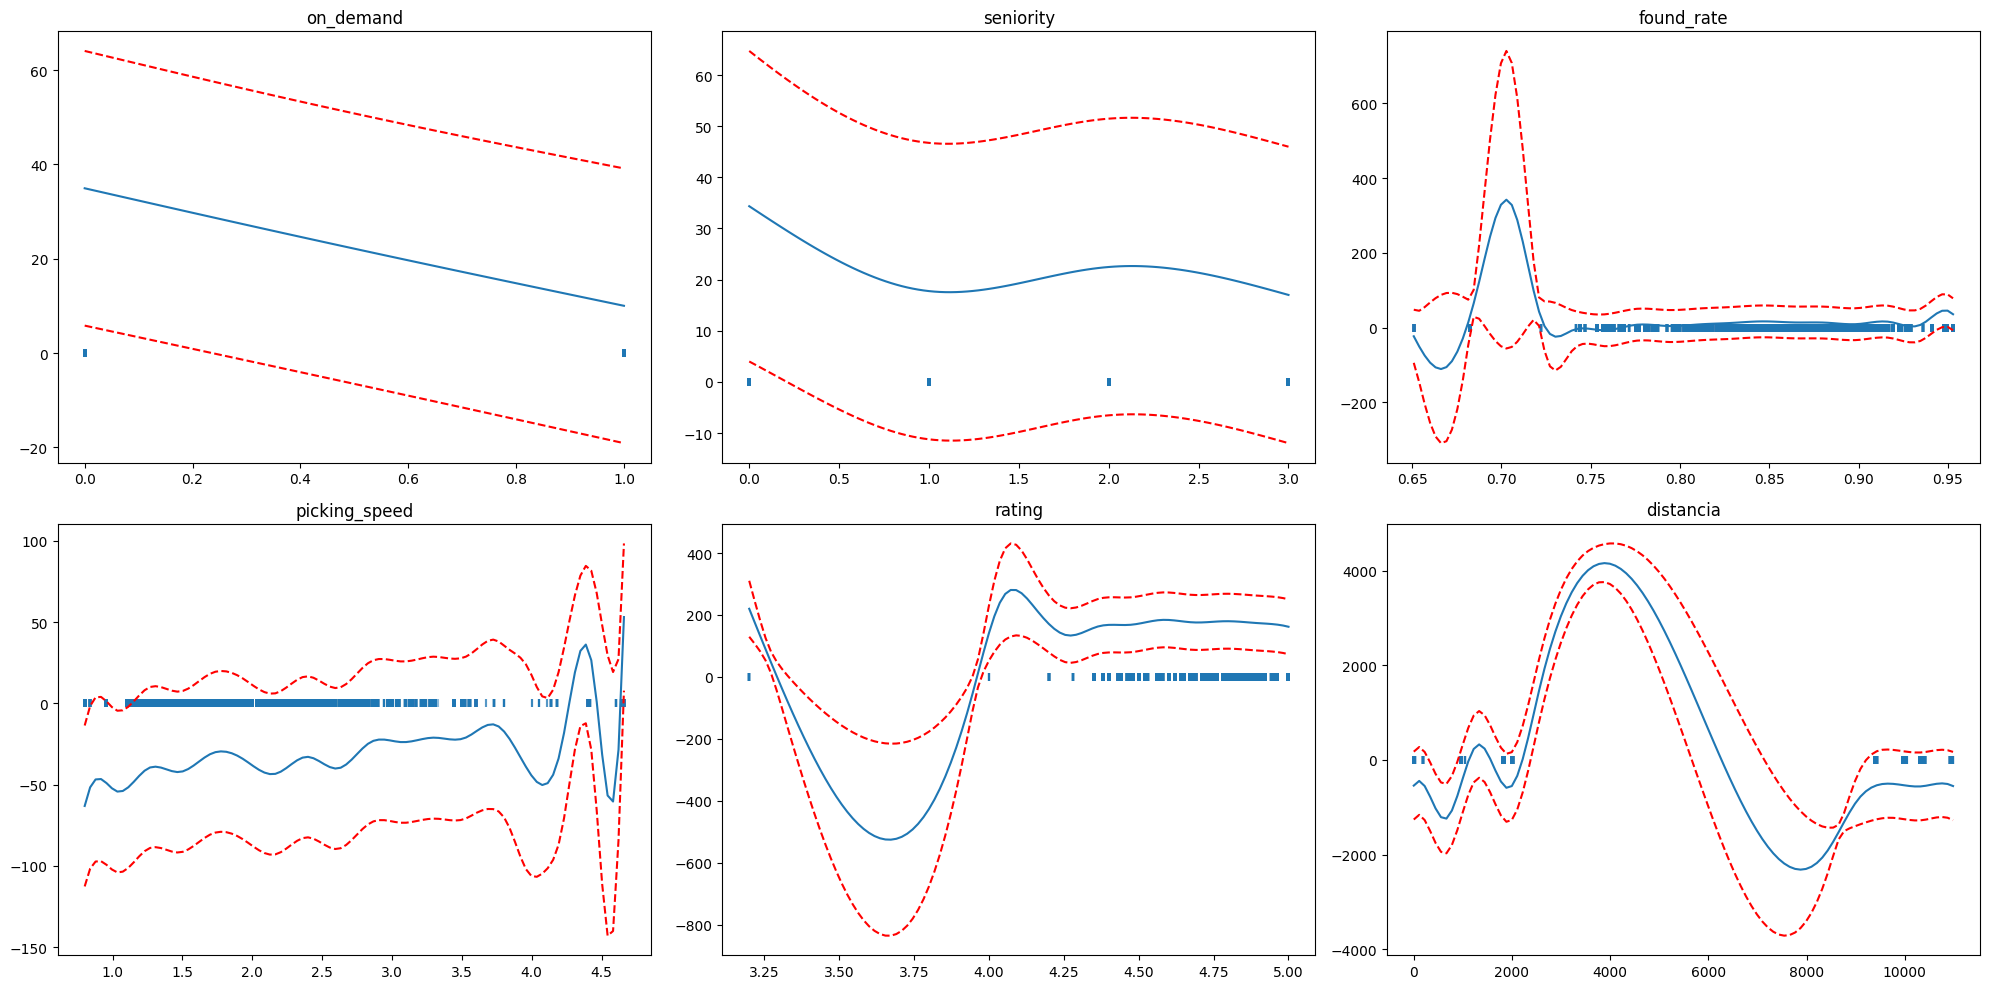

In [141]:

col_drop = ['promised_time', 'order_id', 'picker_id', 'driver_id', 'store_branch_id', 'shopper_id', 'product_id',
            'store', 'total_minutes', 'dow','actual_time', 'accepted_rate', 'quantity', 'quantity_foundun', 'quantity_foundkg']
GAM_numerico = gam_regression_analysis(df_merge, col_drop, 'total_minutes', iteration=2, show_plot=True, previous_results=GAM_numerico)

##### Estadistica

In [142]:
estadistica_modelo(RF_numerico)


,MSE,MAE,R^2
iteracion1,42.012638,1.705303e-13,0.989834
iteracion2,25.020041,1.278977e-13,0.993946


In [143]:
estadistica_modelo(DT_numerico)

,MSE,MAE,R^2
iteracion1,93.199697,7.105427e-15,0.977447
iteracion2,54.981483,1.421085e-14,0.986695


In [144]:
estadistica_modelo(GAM_numerico)

,MSE,MAE,R^2
iteracion1,3883.326012,24.972518,0.060291
iteracion2,3883.206402,25.098819,0.060320


#### iteracion 3
**Tercera reducción de variables:**

se elimina para:

1)Random forest: rating ,accepted_rate, on_demand

2)Decision tree: on_demand , accept_rate, rating

3) GAM : rating, found_rate , seniority

##### Modelo 1 ) Random Forest

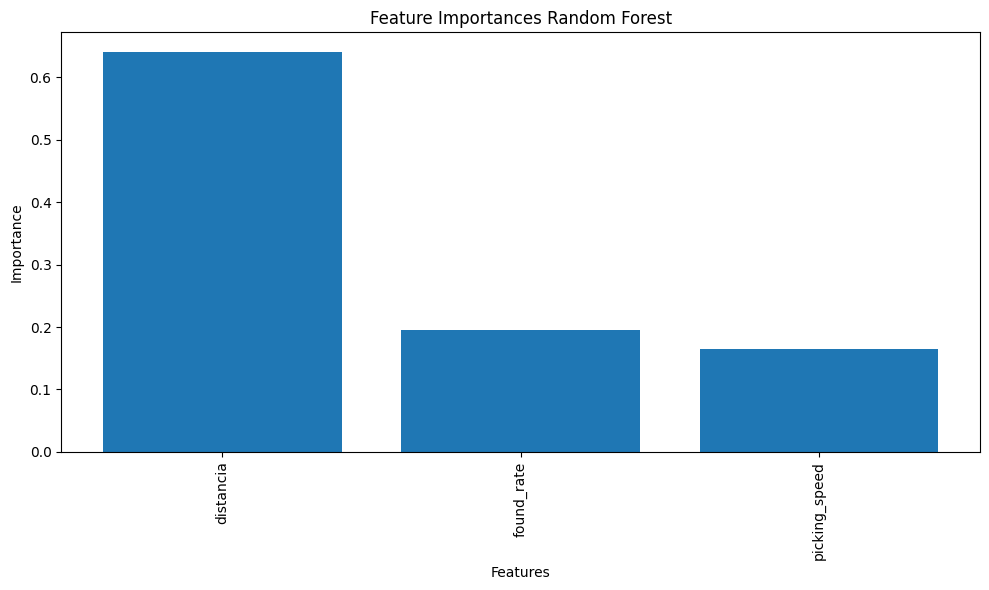

In [145]:
col_drop = ['promised_time', 'order_id', 'picker_id', 'driver_id', 'store_branch_id', 'shopper_id', 'product_id',
            'store', 'total_minutes', 'quantity', 'quantity_foundun',
            'quantity_foundkg', 'dow', 'actual_time', 'rating', 'accepted_rate', 'seniority', 'on_demand']
RF_numerico = random_forest_regression_analysis(df_merge, col_drop, 'total_minutes', iteration=3, show_plot=True, previous_results=RF_numerico)

##### Modelo 2 ) Decision tree

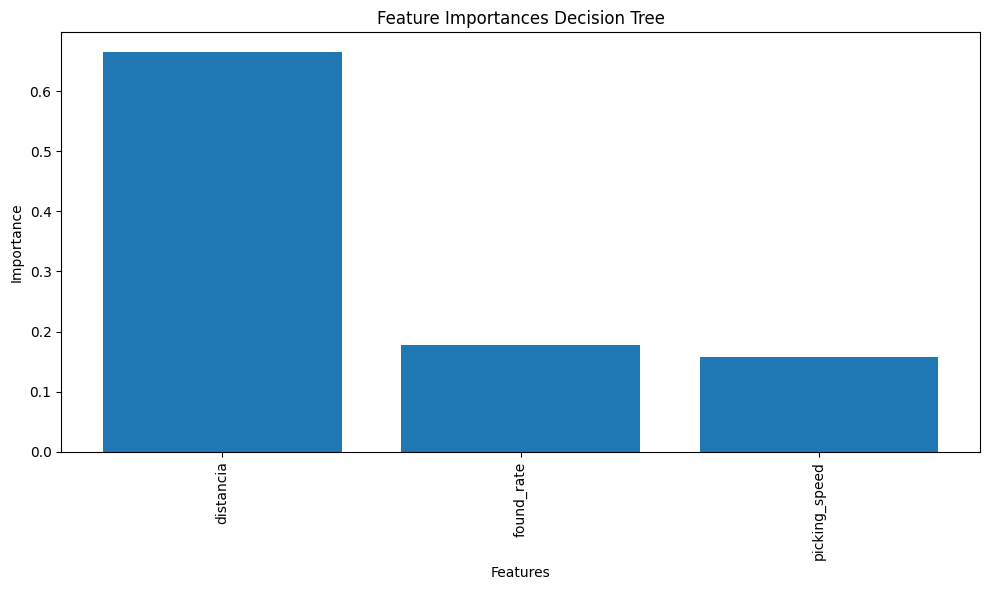

In [146]:
col_drop = ['promised_time', 'order_id', 'picker_id', 'driver_id', 'store_branch_id', 'shopper_id', 'product_id',
            'store', 'total_minutes', 'quantity',
            'quantity_foundun', 'quantity_foundkg', 'dow', 'actual_time', 'on_demand',
            'rating', 'accepted_rate', 'seniority']
DT_numerico = decision_tree_regression_analysis(df_merge, col_drop, 'total_minutes', iteration=3, show_plot=True, previous_results=DT_numerico)

##### Modelo 3 ) GAM

100% (11 of 11) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


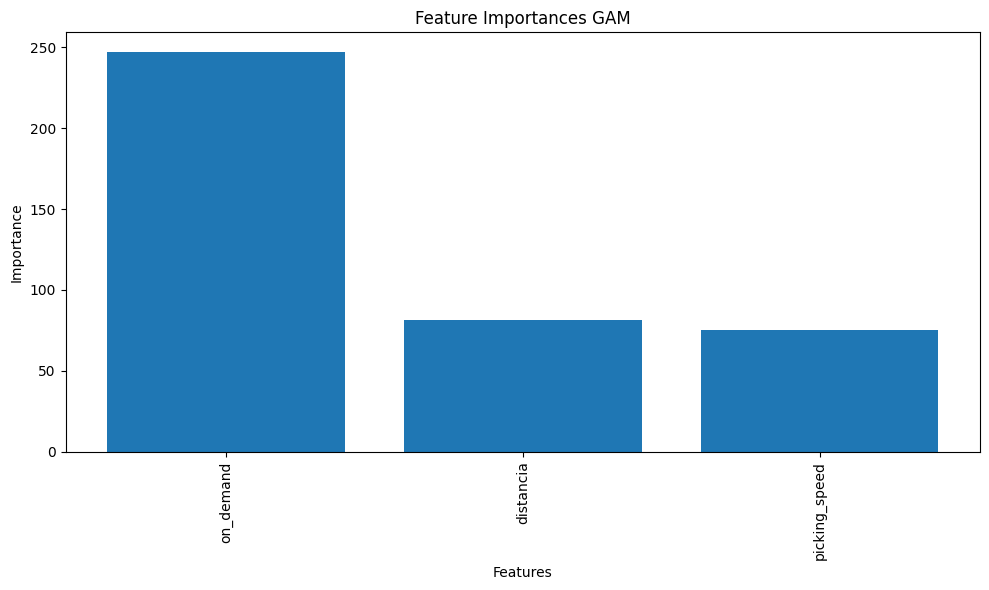

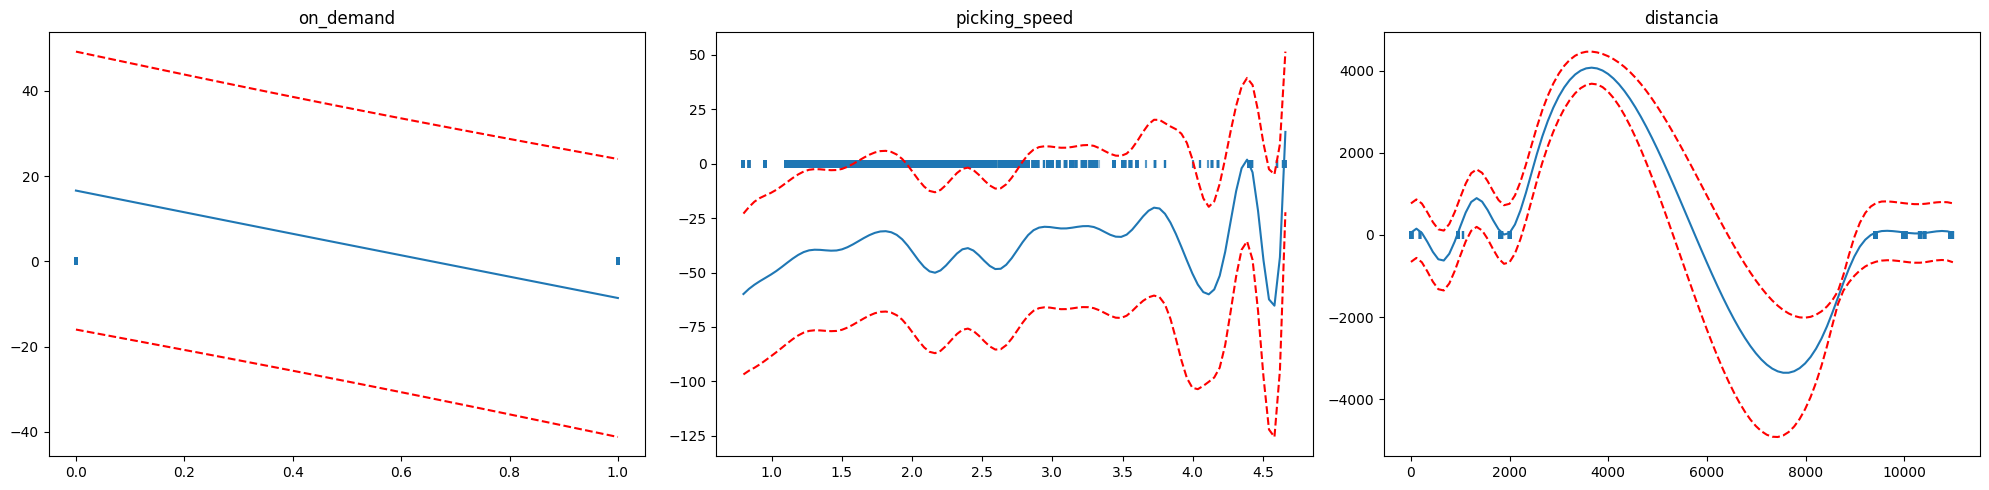

In [147]:
col_drop = ['promised_time', 'order_id', 'picker_id', 'driver_id', 'store_branch_id', 'shopper_id', 'product_id',
            'store', 'total_minutes', 'dow','actual_time', 'accepted_rate', 'quantity', 'quantity_foundun', 'quantity_foundkg', 'rating', 'found_rate' , 'seniority']
GAM_numerico = gam_regression_analysis(df_merge, col_drop, 'total_minutes', iteration=3, show_plot=True, previous_results=GAM_numerico)

##### Estadistica

In [148]:
print("modeles RF")
estadistica_modelo(RF_numerico)

modeles RF


,MSE,MAE,R^2
iteracion1,42.012638,1.705303e-13,0.989834
iteracion2,25.020041,1.278977e-13,0.993946
iteracion3,27.565841,1.278977e-13,0.993329


In [149]:
print("modeles DT")
estadistica_modelo(DT_numerico)

modeles DT


,MSE,MAE,R^2
iteracion1,93.199697,7.105427e-15,0.977447
iteracion2,54.981483,1.421085e-14,0.986695
iteracion3,19.462654,1.421085e-14,0.995290


In [150]:
print("GAM")
estadistica_modelo(GAM_numerico)

GAM


,MSE,MAE,R^2
iteracion1,3883.326012,24.972518,0.060291
iteracion2,3883.206402,25.098819,0.060320
iteracion3,3930.696353,24.923066,0.048828


# 3) Predicciones

In [151]:
new_data = pd.DataFrame({'found_rate': [1.5],'picking_speed': [1.5],'distancia': [5]})


predictions_time = RF_numerico["iteracion3"]["modelRN"].predict(new_data)

print(predictions_time)

[89.38373833]


In [152]:

new_data = pd.DataFrame({'found_rate': [1.5],'picking_speed': [1.5],'distancia': [5]})


predictions_time = DT_numerico["iteracion3"]["modelDT"].predict(new_data)

print(predictions_time)

[85.0096]


In [153]:
new_data = pd.DataFrame({'on_demand': [1.5],'picking_speed': [1.5],'distancia': [5]})


predictions_time = GAM_numerico["iteracion3"]["gam"].predict(new_data)

print(predictions_time)

[82.65520043]


# 4) Predicciones Gridsearch

In [154]:
# RANDOM FOREST GRIDSEARCH
from sklearn.model_selection import GridSearchCV


col_drop = ['promised_time', 'order_id', 'picker_id', 'driver_id', 'store_branch_id', 'shopper_id', 'product_id',
            'store', 'total_minutes', 'quantity',
            'quantity_foundun', 'quantity_foundkg', 'dow', 'actual_time', 'on_demand',
            'rating', 'accepted_rate', 'seniority']


X = df_merge.drop(col_drop, axis=1)
y = df_merge['total_minutes']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


modelRFtm = RandomForestRegressor(random_state=42)


grid_search = GridSearchCV(estimator=modelRFtm, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)


grid_search.fit(X_train, y_train)


print(f'Mejores hiperparámetros:  {grid_search.best_params_}')


best_modelRF = grid_search.best_estimator_
predictions = best_modelRF.predict(X_test)


mse = mean_squared_error(y_test, predictions)
mae = median_absolute_error(y_test, predictions)
r2_ = r2_score(y_test, predictions)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R^2: {r2_}')



Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mejores hiperparámetros:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 2.5579538487363607e-13
MSE: 26.286737828688917
R^2: 0.9936389862493383


In [155]:
 # DECISION TREE GRIDSEARCH

col_drop = ['promised_time', 'order_id', 'picker_id', 'driver_id', 'store_branch_id', 'shopper_id', 'product_id',
            'store', 'total_minutes', 'quantity', 'quantity_foundun', 'quantity_foundkg', 'dow', 'actual_time', 'on_demand',
            'rating', 'accepted_rate', 'seniority']


X = df_merge.drop(col_drop, axis=1)
y = df_merge['total_minutes']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


modelDTtm = DecisionTreeRegressor(random_state=42)


params = {'max_depth': [None, 10, 20, 30, 40, 50],
          'min_samples_split': [2, 5, 10, 20],
          'min_samples_leaf': [1, 2, 5, 10]}


grid_search = GridSearchCV(estimator=modelDTtm, param_grid=params, cv=5, scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train)


print('Mejores hiperparámetros: ', grid_search.best_params_)


best_modelDT = grid_search.best_estimator_
predictions = best_modelDT.predict(X_test)


mse = mean_squared_error(y_test, predictions)
mae = median_absolute_error(y_test, predictions)
r2_ = r2_score(y_test, predictions)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R^2: {r2_}')


Mejores hiperparámetros:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
MAE: 1.4210854715202004e-14
MSE: 20.9373142510727
R^2: 0.9949334700744934


In [156]:
def gam_regression_analysis(df_merge, col_drop, target_column):

    X = df_merge.drop(col_drop, axis=1)
    y = df_merge[target_column]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    X_train = X_train.astype(float)
    X_test = X_test.astype(float)

    terms = sum((s(i) for i in range(X_train.shape[1])), s(0))


    gamGS = LinearGAM(terms).gridsearch(X_train.values, y_train.values)


    predictions = gamGS.predict(X_test)


    mse = mean_squared_error(y_test, predictions)
    mae = median_absolute_error(y_test, predictions)
    r2_ = r2_score(y_test, predictions)

    results_dict = {'MSE': mse, 'MAE': mae, 'R^2': r2_}

    return results_dict

In [157]:
col_drop = ['promised_time', 'order_id', 'picker_id', 'driver_id', 'store_branch_id', 'shopper_id', 'product_id',
            'store', 'total_minutes', 'quantity', 'quantity_foundun',
            'quantity_foundkg', 'dow', 'actual_time', 'on_demand',
            'rating', 'accepted_rate', 'seniority']

gam_regression_analysis(df_merge, col_drop,'total_minutes')

100% (11 of 11) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


{'MSE': 4013.2598708459905,
 'MAE': 25.943303205426197,
 'R^2': 0.02884863881554578}

# 5) conclusiones

Desde la segunda iteración, tanto el modelo de Árbol de Decisión como el de Random Forest continuaron mejorando en todas las métricas, mientras que el modelo de GAM siguió mostrando un rendimiento inferior.
En la tercera iteración, los modelos de Árbol de Decisión y Random Forest mantuvieron su buen desempeño, mientras que el modelo de GAM siguió siendo inferior en todas las métricas.
En general, se observa que los modelos de Random Forest y Árbol de Decisión mostraron una mejora consistente en todas las iteraciones, mientras que el modelo de GAM no logró mejorar y mostró un rendimiento inferior en comparación.


El modelo Random Forest es el mejor de los tres, ya que presenta el valor más bajo de MSE (Mean Squared Error) y MAE (Mean Absolute Error), y el valor más alto de R^2 (Coeficiente de determinación). Esto indica que el modelo Random Forest tiene un mejor rendimiento en términos de precisión y capacidad de explicar la variabilidad en los datos.

El modelo Random Forest supera a los otros dos modelos evaluados en términos de precisión y capacidad de explicación de la variabilidad en los datos, presentando el menor error y el mayor coeficiente de determinación. Es una elección sólida para realizar predicciones en este contexto.

De mejor a peor rendimiento de la siguiente manera:

- 1.Random Forest: Presenta el menor MSE y MAE, y el mayor R^2, lo que indica una alta precisión y capacidad de explicación de la  variabilidad en los datos.

- 2.Decision Tree: Aunque ligeramente inferior al Random Forest, este modelo también muestra un buen rendimiento con valores bajos de MSE y MAE, y un alto R^2.

- 3.Linear GAM: Este modelo muestra el peor rendimiento en comparación con los otros dos. Tiene un MSE y MAE significativamente más altos y un valor de R^2 bastante bajo, lo que indica una menor capacidad para explicar la variabilidad en los datos y una mayor discrepancia entre las predicciones y los valores reales.

## En resumen, el ranking de mejor a peor rendimiento sería: Random Forest > Decision Tree > Linear GAM.
